#  Annotation

## Settings 

In [2]:
# Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/ext_ana/processed'
test = 'sample1'

# Gene annotation
GTF_PATH = "/mnt/workspace/jdetlef/ext_ana/mus_musculus.104.genes.gtf"
# Cell type annotation
PANGLAO_DB_PATH = "/mnt/workspace/jdetlef/sc-atac-framework/ctannot/panglao_markers"

## Loading packages and setup

In [3]:
import sctoolbox.atac_tree as sub_tree
import sctoolbox.annotation as annot
import sctoolbox.custom_celltype_annotation as ctannot
import episcanpy as epi
import scanpy as sc
from matplotlib import pyplot as plt
from pybiomart import Dataset

## Setup path handling object 

In [4]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


In [5]:
tree.gtf_path = GTF_PATH

## Load anndata

In [6]:
clustering_output = tree.clustering_anndata
adata = epi.read_h5ad(clustering_output)
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,prop_shared_cells,variability_score,highly_variable
annotated_peaks_0_chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,0.002400,0.002398,99.759962,15.0,2.772589,15.0,22.0,0.002400,0.502400,False
annotated_peaks_100000_chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,0.085934,0.082440,91.406625,537.0,6.287858,537.0,995.0,0.085934,0.585934,True
annotated_peaks_100001_chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,0.019043,0.018864,98.095695,119.0,4.787492,119.0,211.0,0.019043,0.519043,False
annotated_peaks_100003_chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,0.006081,0.006063,99.391903,38.0,3.663562,38.0,113.0,0.006081,0.506081,False
annotated_peaks_100004_chr4:129534299-129535110,chr4,129534299,129535110,peak_100005,.,.,gene,129519870.0,129534858.0,-,...,0.102896,0.097940,89.710354,643.0,6.467699,643.0,1202.0,0.102896,0.602896,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
annotated_peaks_99998_chr4:129515107-129515508,chr4,129515107,129515508,peak_99999,.,.,gene,129508918.0,129512892.0,-,...,0.025924,0.025594,97.407585,162.0,5.093750,162.0,322.0,0.025924,0.525924,False
annotated_peaks_99999_chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,0.019043,0.018864,98.095695,119.0,4.787492,119.0,246.0,0.019043,0.519043,False
annotated_peaks_9999_chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,0.007201,0.007175,99.279885,45.0,3.828641,45.0,80.0,0.007201,0.507201,False
annotated_peaks_999_chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,0.004161,0.004152,99.583933,26.0,3.295837,26.0,52.0,0.004161,0.504161,False


In [7]:
#adata.var.index = adata.var.index.str.replace('_',' ')
    

In [8]:
adata.var['peak_chr'] = adata.var['peak_chr'].astype(str)
adata.var['peak_start'] = adata.var['peak_start'].astype(int)
adata.var['peak_end'] = adata.var['peak_end'].astype(int)

#import re
#names = adata.var.index
#peak_chr_list = []
#peak_start_list = []
#peak_end_list = []
#regex = r'[^_:\-]+[\_\:\-]+[0-9]+[\_\:\-]+[0-9]+'
#for name in names:
#    if re.match(regex, name):  # test if name can be split by regex
#
#        # split the name into chr, start, end
#        split_name = re.split(r'[\_\:\-]', name)
#        peak_chr_list.append(split_name[0])
#        peak_start_list.append(int(split_name[1]))
#        peak_end_list.append(int(split_name[2]))
#adata.var['peak_chr'] = peak_chr_list
#adata.var['peak_start'] = peak_start_list
#adata.var['peak_end'] = peak_end_list


In [9]:
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,prop_shared_cells,variability_score,highly_variable
annotated_peaks_0_chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,0.002400,0.002398,99.759962,15.0,2.772589,15.0,22.0,0.002400,0.502400,False
annotated_peaks_100000_chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,0.085934,0.082440,91.406625,537.0,6.287858,537.0,995.0,0.085934,0.585934,True
annotated_peaks_100001_chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,0.019043,0.018864,98.095695,119.0,4.787492,119.0,211.0,0.019043,0.519043,False
annotated_peaks_100003_chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,0.006081,0.006063,99.391903,38.0,3.663562,38.0,113.0,0.006081,0.506081,False
annotated_peaks_100004_chr4:129534299-129535110,chr4,129534299,129535110,peak_100005,.,.,gene,129519870.0,129534858.0,-,...,0.102896,0.097940,89.710354,643.0,6.467699,643.0,1202.0,0.102896,0.602896,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
annotated_peaks_99998_chr4:129515107-129515508,chr4,129515107,129515508,peak_99999,.,.,gene,129508918.0,129512892.0,-,...,0.025924,0.025594,97.407585,162.0,5.093750,162.0,322.0,0.025924,0.525924,False
annotated_peaks_99999_chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,0.019043,0.018864,98.095695,119.0,4.787492,119.0,246.0,0.019043,0.519043,False
annotated_peaks_9999_chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,0.007201,0.007175,99.279885,45.0,3.828641,45.0,80.0,0.007201,0.507201,False
annotated_peaks_999_chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,0.004161,0.004152,99.583933,26.0,3.295837,26.0,52.0,0.004161,0.504161,False


## Gene annotation 

In [10]:
annot.annotate_adata(adata,
                   GTF_PATH,
                   config=None,
                   best=True,
                   threads=6,
                   coordinate_cols=None,
                   temp_dir="",
                   verbose=True,
                   inplace=True)

Setting up annotation configuration...
Config dictionary: {'queries': [{'distance': [10000, 1000], 'feature_anchor': ['start'], 'feature': ['gene'], 'name': 'promoters'}], 'priority': True, 'show_attributes': ['all'], 'output_by_query': False}
Setting up genomic regions to annotate...
Index(['peak_chr', 'peak_start', 'peak_end'], dtype='object')
Preparing gtf file for annotation...
- Reading gtf with Tabix
- Index of gtf not found - trying to index gtf
- Reading gtf with Tabix
Done preparing gtf!
Annotating regions...
Formatting annotations...
These columns will be overwritten by the annotation
Finished annotation of features! The results are found in the .var table.
[Errno 2] No such file or directory: ''


In [11]:
adata.var['gene_name']

annotated_peaks_0_chr1:3050427-3050801                 NaN
annotated_peaks_100000_chr4:129518038-129518515    Ccdc28b
annotated_peaks_100001_chr4:129518849-129519134    Ccdc28b
annotated_peaks_100003_chr4:129533947-129534180      Txlna
annotated_peaks_100004_chr4:129534299-129535110      Txlna
                                                    ...   
annotated_peaks_99998_chr4:129515107-129515508        Iqcc
annotated_peaks_99999_chr4:129517580-129517846     Ccdc28b
annotated_peaks_9999_chr1:192477325-192477572          NaN
annotated_peaks_999_chr1:37026210-37026612             NaN
annotated_peaks_9_chr1:3191548-3191937                 NaN
Name: gene_name, Length: 118387, dtype: category
Categories (23924, object): ['0610006L08Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', ..., 'mmu-mir-7094-1', 'mmu-mir-7676-1', 'mmu-mir-7679', 'n-R5s41']

In [12]:
assigned_features = adata.var['gene_name'].dropna()
assigned_features

annotated_peaks_100000_chr4:129518038-129518515    Ccdc28b
annotated_peaks_100001_chr4:129518849-129519134    Ccdc28b
annotated_peaks_100003_chr4:129533947-129534180      Txlna
annotated_peaks_100004_chr4:129534299-129535110      Txlna
annotated_peaks_100005_chr4:129539961-129540183      Txlna
                                                    ...   
annotated_peaks_99995_chr4:129502294-129503161       Eif3i
annotated_peaks_99996_chr4:129503825-129504508       Eif3i
annotated_peaks_99997_chr4:129512576-129513315        Iqcc
annotated_peaks_99998_chr4:129515107-129515508        Iqcc
annotated_peaks_99999_chr4:129517580-129517846     Ccdc28b
Name: gene_name, Length: 38944, dtype: category
Categories (23924, object): ['0610006L08Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', ..., 'mmu-mir-7094-1', 'mmu-mir-7676-1', 'mmu-mir-7679', 'n-R5s41']

In [13]:
dataset = Dataset(name='hsapiens_gene_ensembl',
                  host='http://www.ensembl.org')

df = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])

In [14]:
ens_dict = dict(zip(df['Gene stable ID'], df['Gene name']))

In [15]:
count = 0
for index, gene in enumerate(assigned_features):
    if gene.startswith("ENSG"):
        if gene in ens_dict.keys():
            if isinstance(ens_dict[gene], str):
                assigned_features.replace(gene, ens_dict[gene], inplace=True)
                count += 1
print(f'{count} ensembl gene ids have been replaced with gene names')

0 ensembl gene ids have been replaced with gene names


In [16]:
assigned_features

annotated_peaks_100000_chr4:129518038-129518515    Ccdc28b
annotated_peaks_100001_chr4:129518849-129519134    Ccdc28b
annotated_peaks_100003_chr4:129533947-129534180      Txlna
annotated_peaks_100004_chr4:129534299-129535110      Txlna
annotated_peaks_100005_chr4:129539961-129540183      Txlna
                                                    ...   
annotated_peaks_99995_chr4:129502294-129503161       Eif3i
annotated_peaks_99996_chr4:129503825-129504508       Eif3i
annotated_peaks_99997_chr4:129512576-129513315        Iqcc
annotated_peaks_99998_chr4:129515107-129515508        Iqcc
annotated_peaks_99999_chr4:129517580-129517846     Ccdc28b
Name: gene_name, Length: 38944, dtype: category
Categories (23924, object): ['0610006L08Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', ..., 'mmu-mir-7094-1', 'mmu-mir-7676-1', 'mmu-mir-7679', 'n-R5s41']

In [17]:
assigned_adata = adata[:, assigned_features.index]
assigned_adata

View of AnnData object with n_obs × n_vars = 6249 × 38944
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nb_features', 'log_nb_features', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'clustering'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand', 'feature', 'region_length', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'l

In [18]:
peaks_adata = assigned_adata.copy()

## Rank peaks

In [19]:
adata.obs['clustering']


barcode
CCATGATGAATCTGTG-sample1    2
TGTTATCACGCTAGAG-sample1    2
GAACTACTGTATTGCG-sample1    3
TACCGACCTCGAACGA-sample1    5
TGAATGGCTTAGGAGC-sample1    1
                           ..
TATTCAGCTTGGAACG-sample1    3
CCTGCCTCTAGCGCTC-sample1    3
TGGTTAGACACACAAA-sample1    3
CGCAAATACGGAGTCA-sample1    4
TGCACGGACTCTGTGA-sample1    3
Name: clustering, Length: 6249, dtype: category
Categories (5, object): ['1', '2', '3', '4', '5']

In [20]:
adata.uns

OverloadedDict, wrapping:
	{'clustering_colors': array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
      dtype=object), 'color_set': array(['red', 'blue', 'green', 'pink', 'chartreuse', 'gray', 'yellow',
       'brown', 'purple', 'orange', 'wheat', 'lightseagreen', 'cyan',
       'khaki', 'cornflowerblue', 'olive', 'gainsboro', 'darkmagenta',
       'slategray', 'ivory', 'darkorchid', 'papayawhip', 'paleturquoise',
       'oldlace', 'orangered', 'lavenderblush', 'gold', 'seagreen',
       'deepskyblue', 'lavender', 'peru', 'silver', 'midnightblue',
       'antiquewhite', 'blanchedalmond', 'firebrick', 'greenyellow',
       'thistle', 'powderblue', 'darkseagreen', 'darkolivegreen',
       'moccasin', 'olivedrab', 'mediumseagreen', 'lightgray',
       'darkgreen', 'tan', 'yellowgreen', 'peachpuff', 'cornsilk',
       'darkblue', 'violet', 'cadetblue', 'palegoldenrod',
       'darkturquoise', 'sienna', 'mediumorchid', 'springgreen',
       'darkgoldenrod', 'magenta', 'steelbl

In [21]:
peaks_adata.uns['log1p']['base'] = None

In [22]:
# TODO save ALL clustering resolutions in infoprocess!
# Workaround:
resolutions = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']

In [23]:
for res in resolutions:
    print(f'Ranking peaks for leiden clusters with resolution: {res}')
    epi.tl.rank_features(peaks_adata, f'leiden_{res}', omic='ATAC', 
                         key_added=f'rank_features_groups_{res}', n_features=100, use_raw=False)
    
print('Done')

Ranking peaks for leiden clusters with resolution: 0.1
Ranking peaks for leiden clusters with resolution: 0.2
Ranking peaks for leiden clusters with resolution: 0.3
Ranking peaks for leiden clusters with resolution: 0.4
Ranking peaks for leiden clusters with resolution: 0.5
Ranking peaks for leiden clusters with resolution: 0.6
Ranking peaks for leiden clusters with resolution: 0.7
Ranking peaks for leiden clusters with resolution: 0.8
Ranking peaks for leiden clusters with resolution: 0.9
Done


## Rank genes
Replace peaks with gene names

In [24]:
genes_adata = peaks_adata.copy()
genes_adata.var.reset_index(inplace=True)  # remove peaks from index and save them in the column ['index']
genes_adata.var.set_index('gene_name',inplace=True)  # set genes as index
genes_adata.var.index = genes_adata.var.index.astype('str')  # to avoid index being categorical
genes_adata.var_names_make_unique(join='_')
genes_adata.raw = genes_adata

In [25]:
for res in resolutions:
    print(f'Ranking genes groups for leiden clusters with resolution: {res}')
    sc.tl.rank_genes_groups(genes_adata, groupby=f'leiden_{res}', use_raw=False, key_added=f'rank_genes_groups_{res}')

print('Done')

Ranking genes groups for leiden clusters with resolution: 0.1
Ranking genes groups for leiden clusters with resolution: 0.2
Ranking genes groups for leiden clusters with resolution: 0.3
Ranking genes groups for leiden clusters with resolution: 0.4
Ranking genes groups for leiden clusters with resolution: 0.5
Ranking genes groups for leiden clusters with resolution: 0.6
Ranking genes groups for leiden clusters with resolution: 0.7
Ranking genes groups for leiden clusters with resolution: 0.8
Ranking genes groups for leiden clusters with resolution: 0.9
Done


### Plot ranked genes

Plotting ranked genes groups for leiden with resolution: 0.1


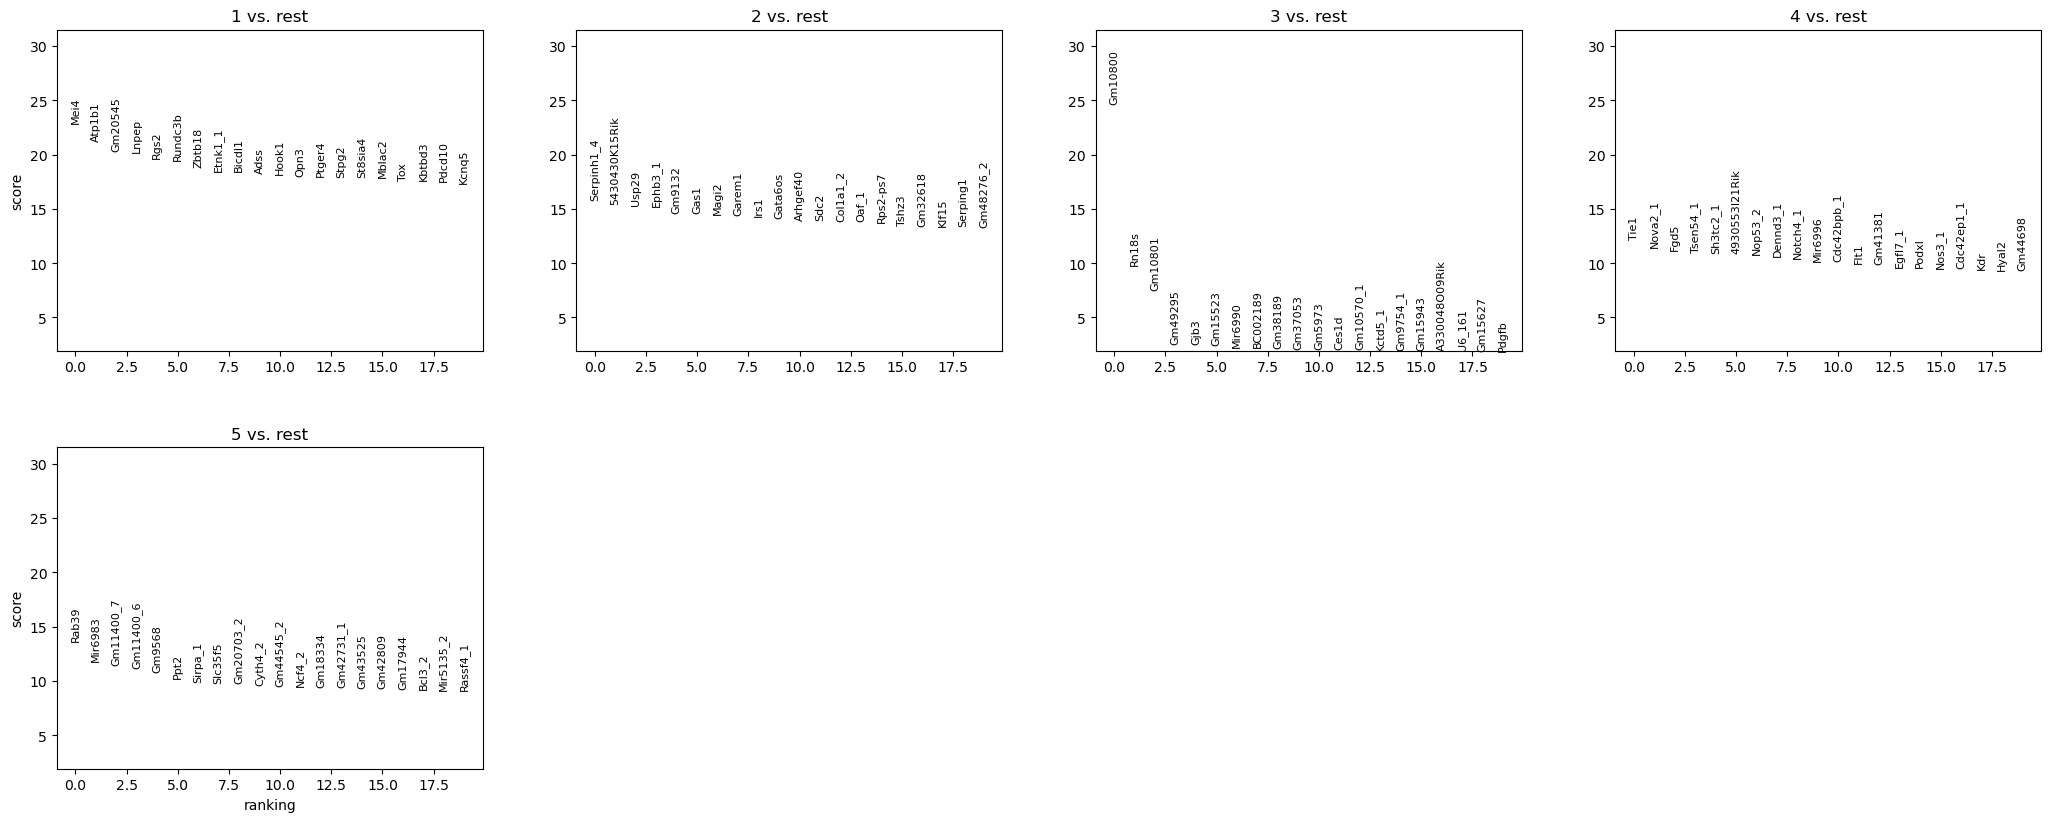

Plotting ranked genes groups for leiden with resolution: 0.2


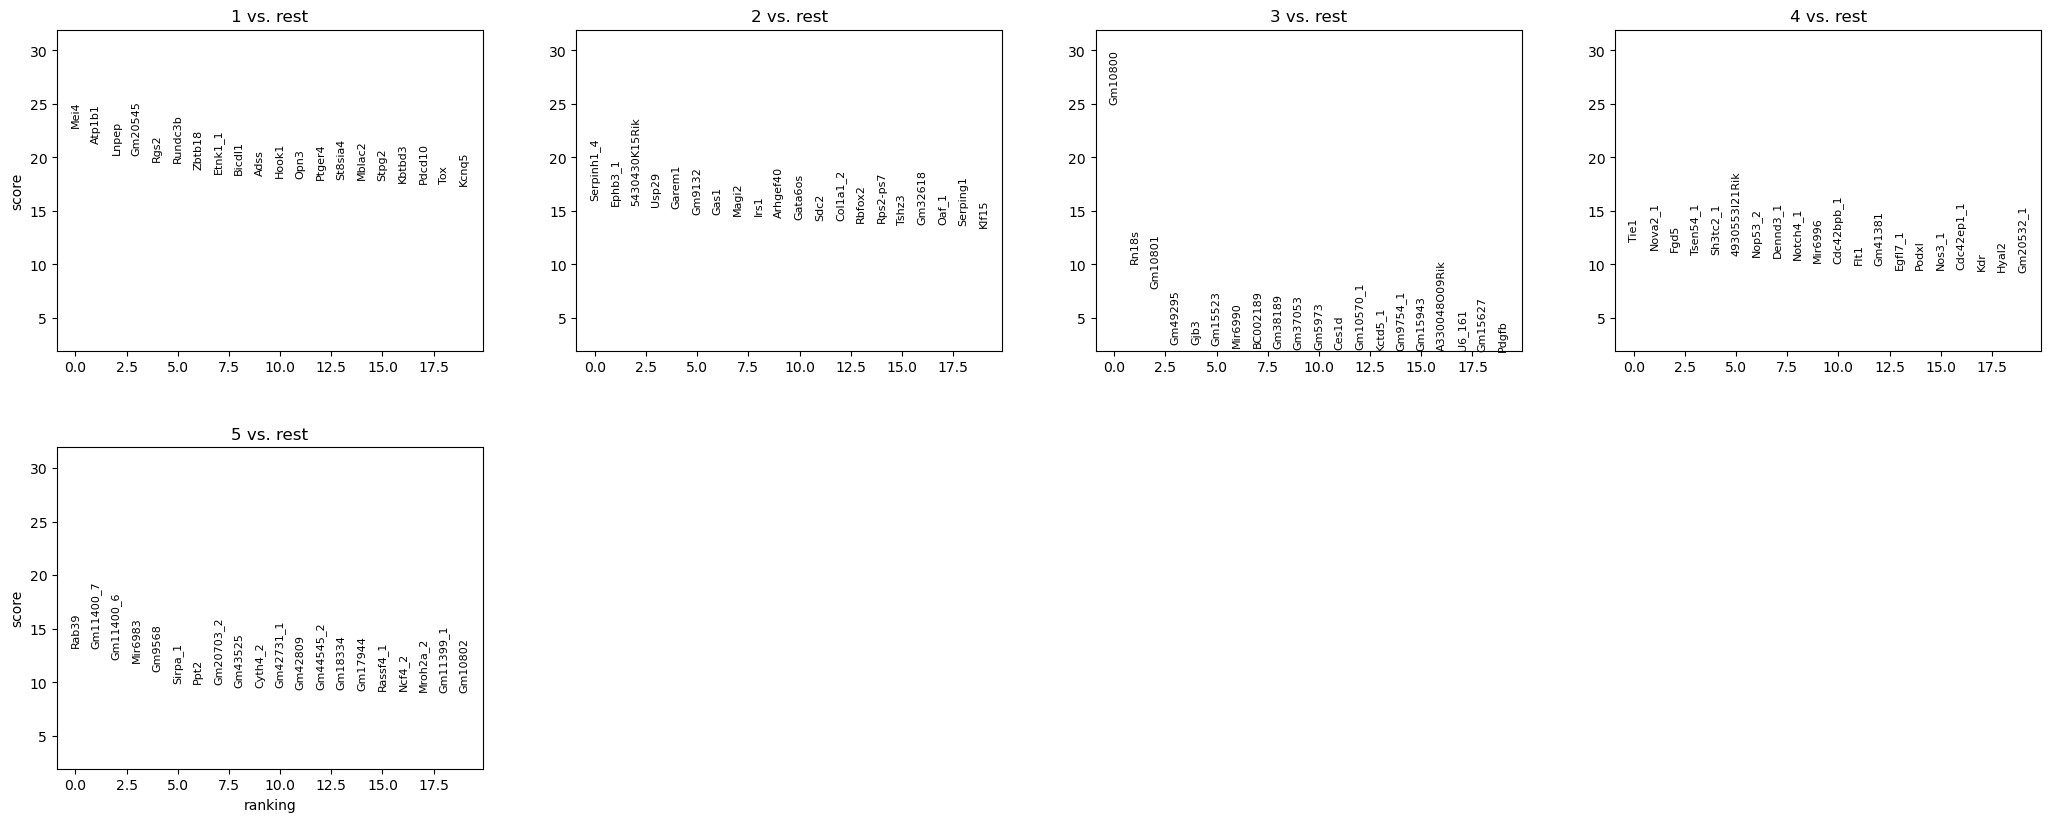

Plotting ranked genes groups for leiden with resolution: 0.3


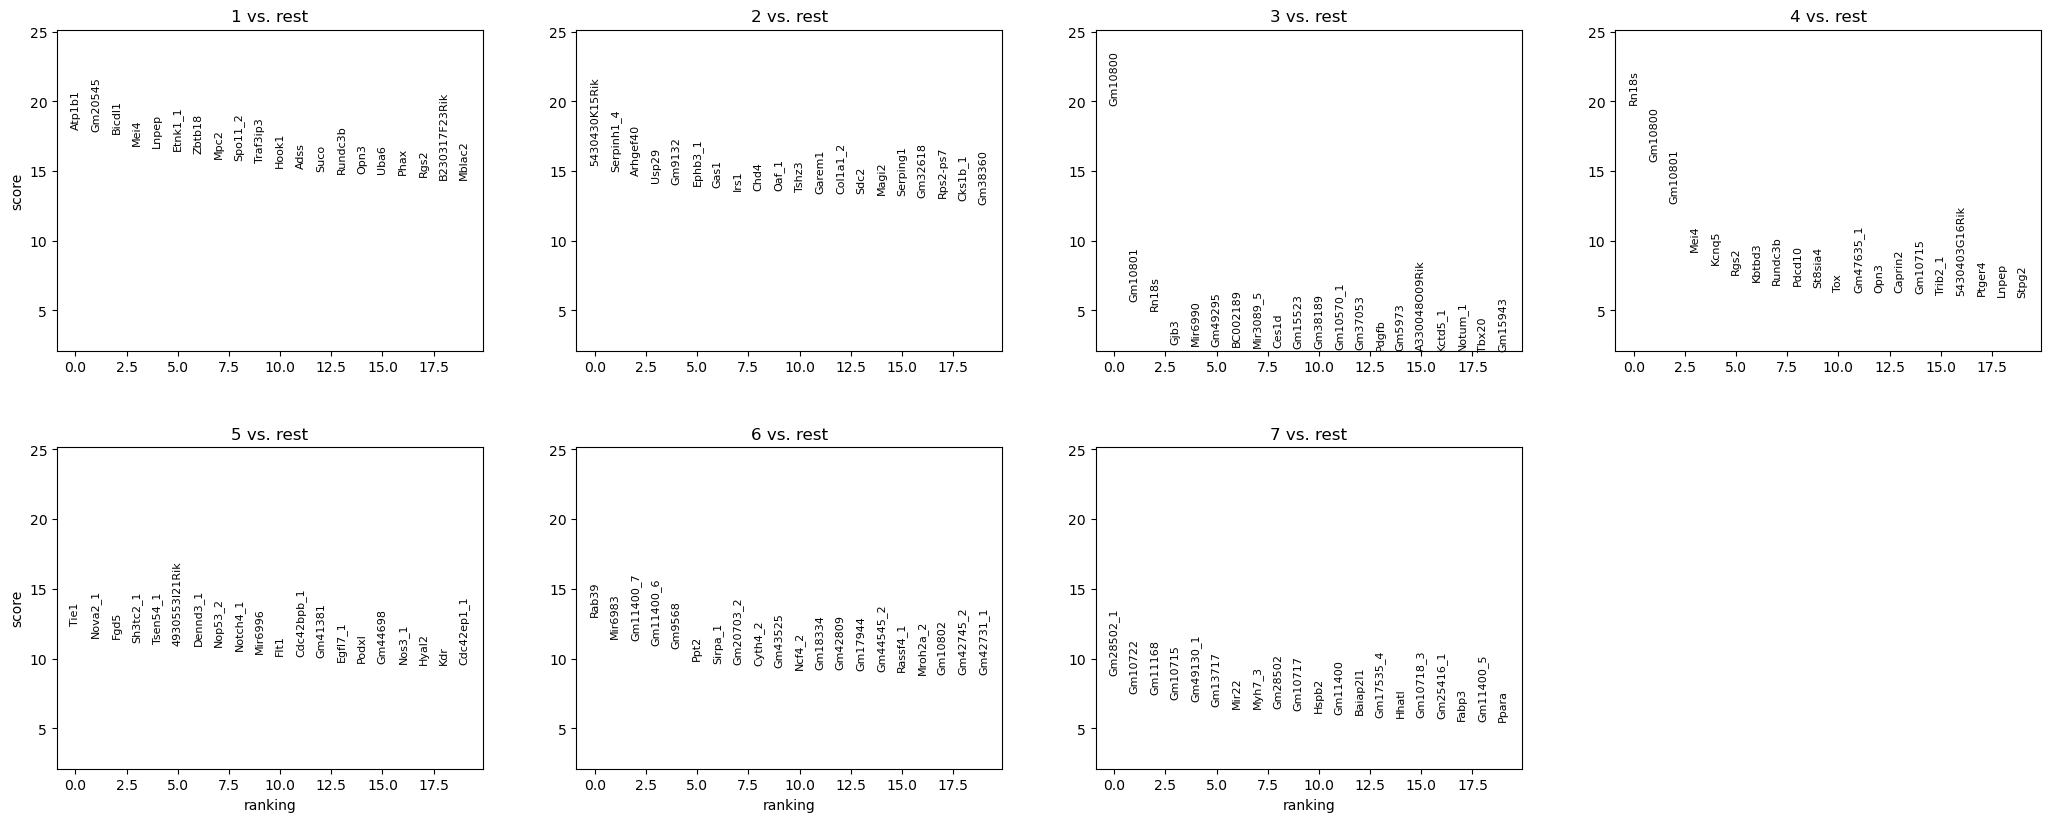

Plotting ranked genes groups for leiden with resolution: 0.4


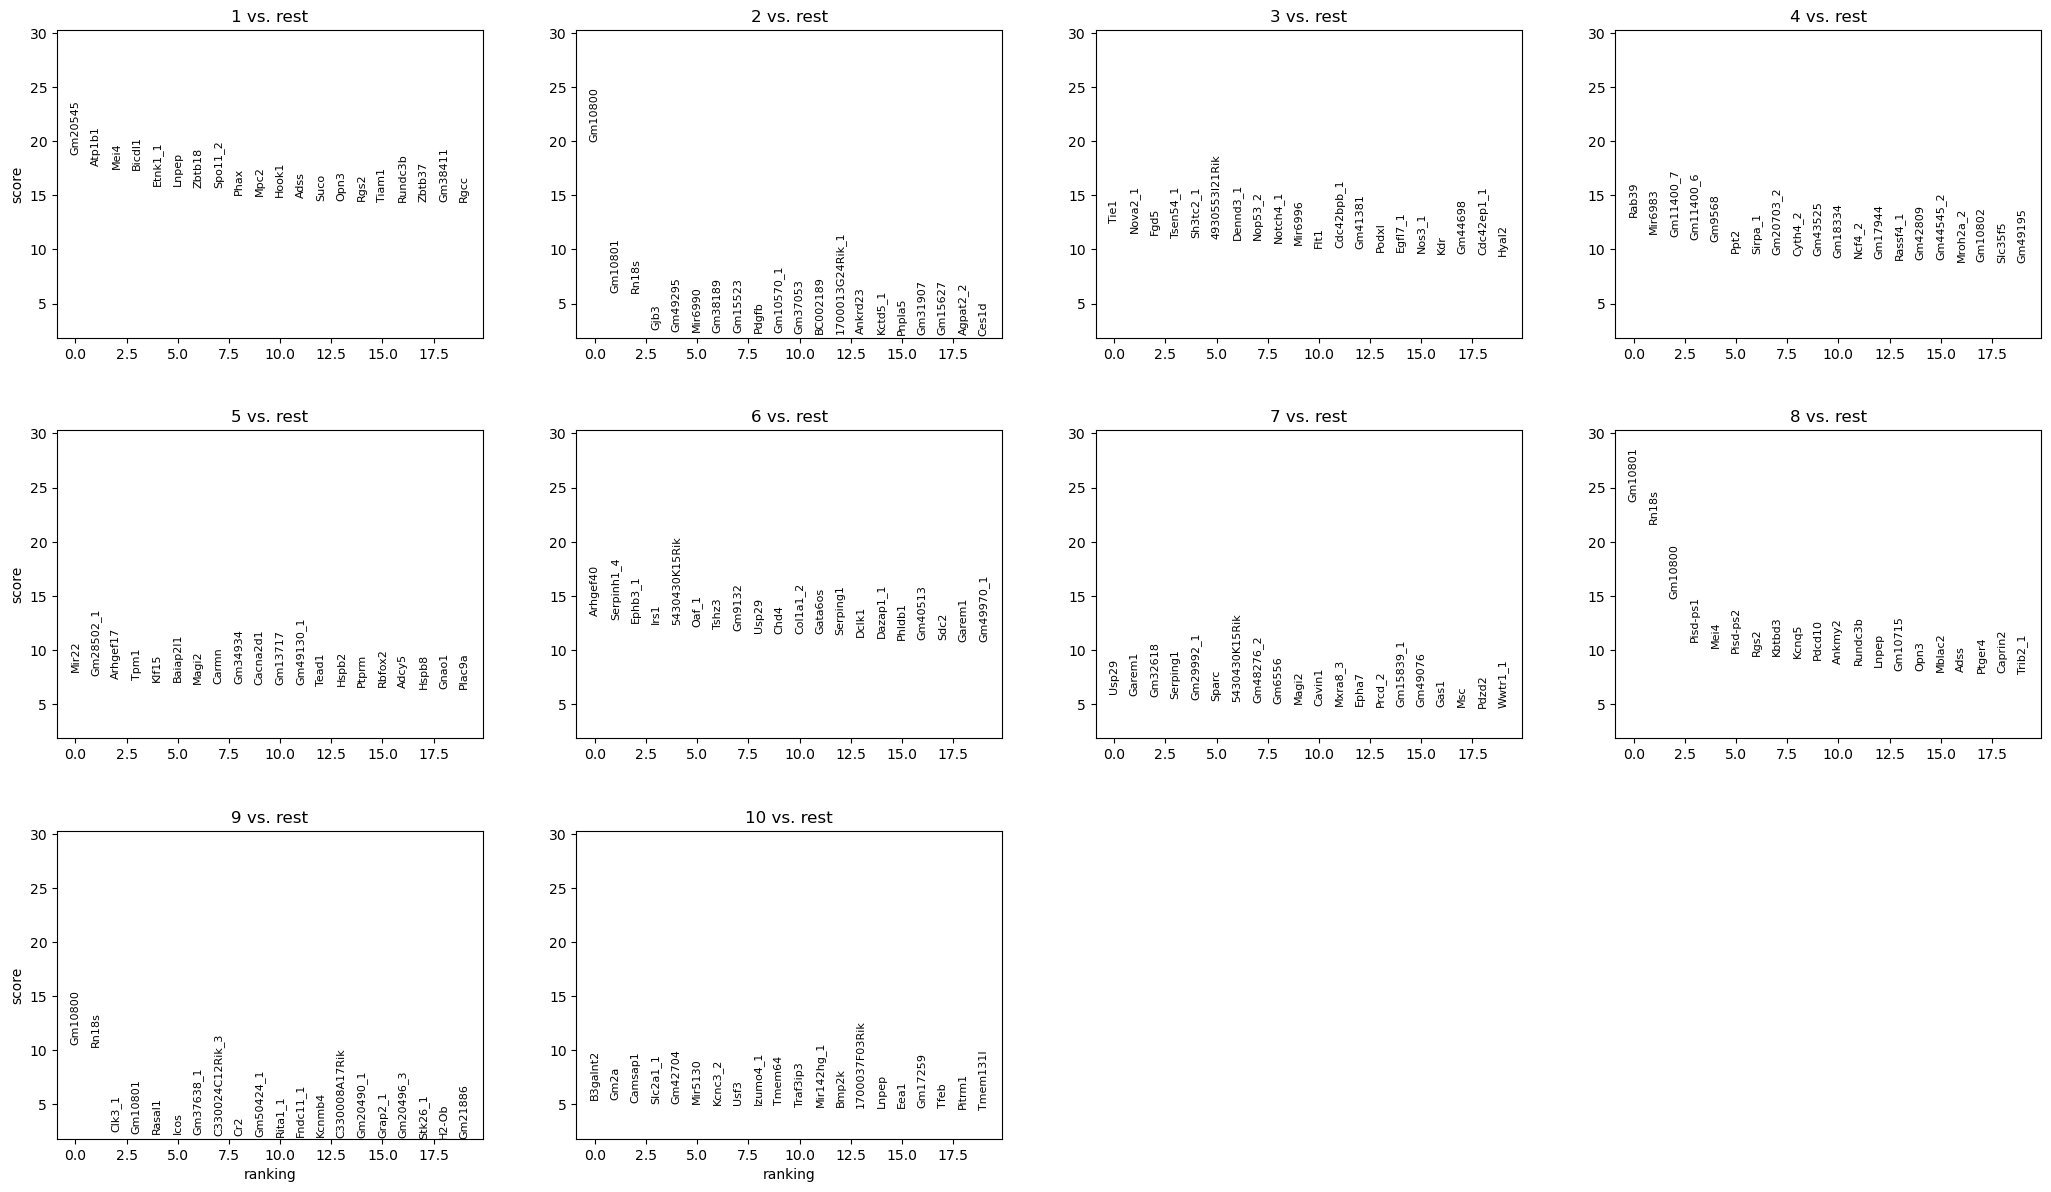

Plotting ranked genes groups for leiden with resolution: 0.5


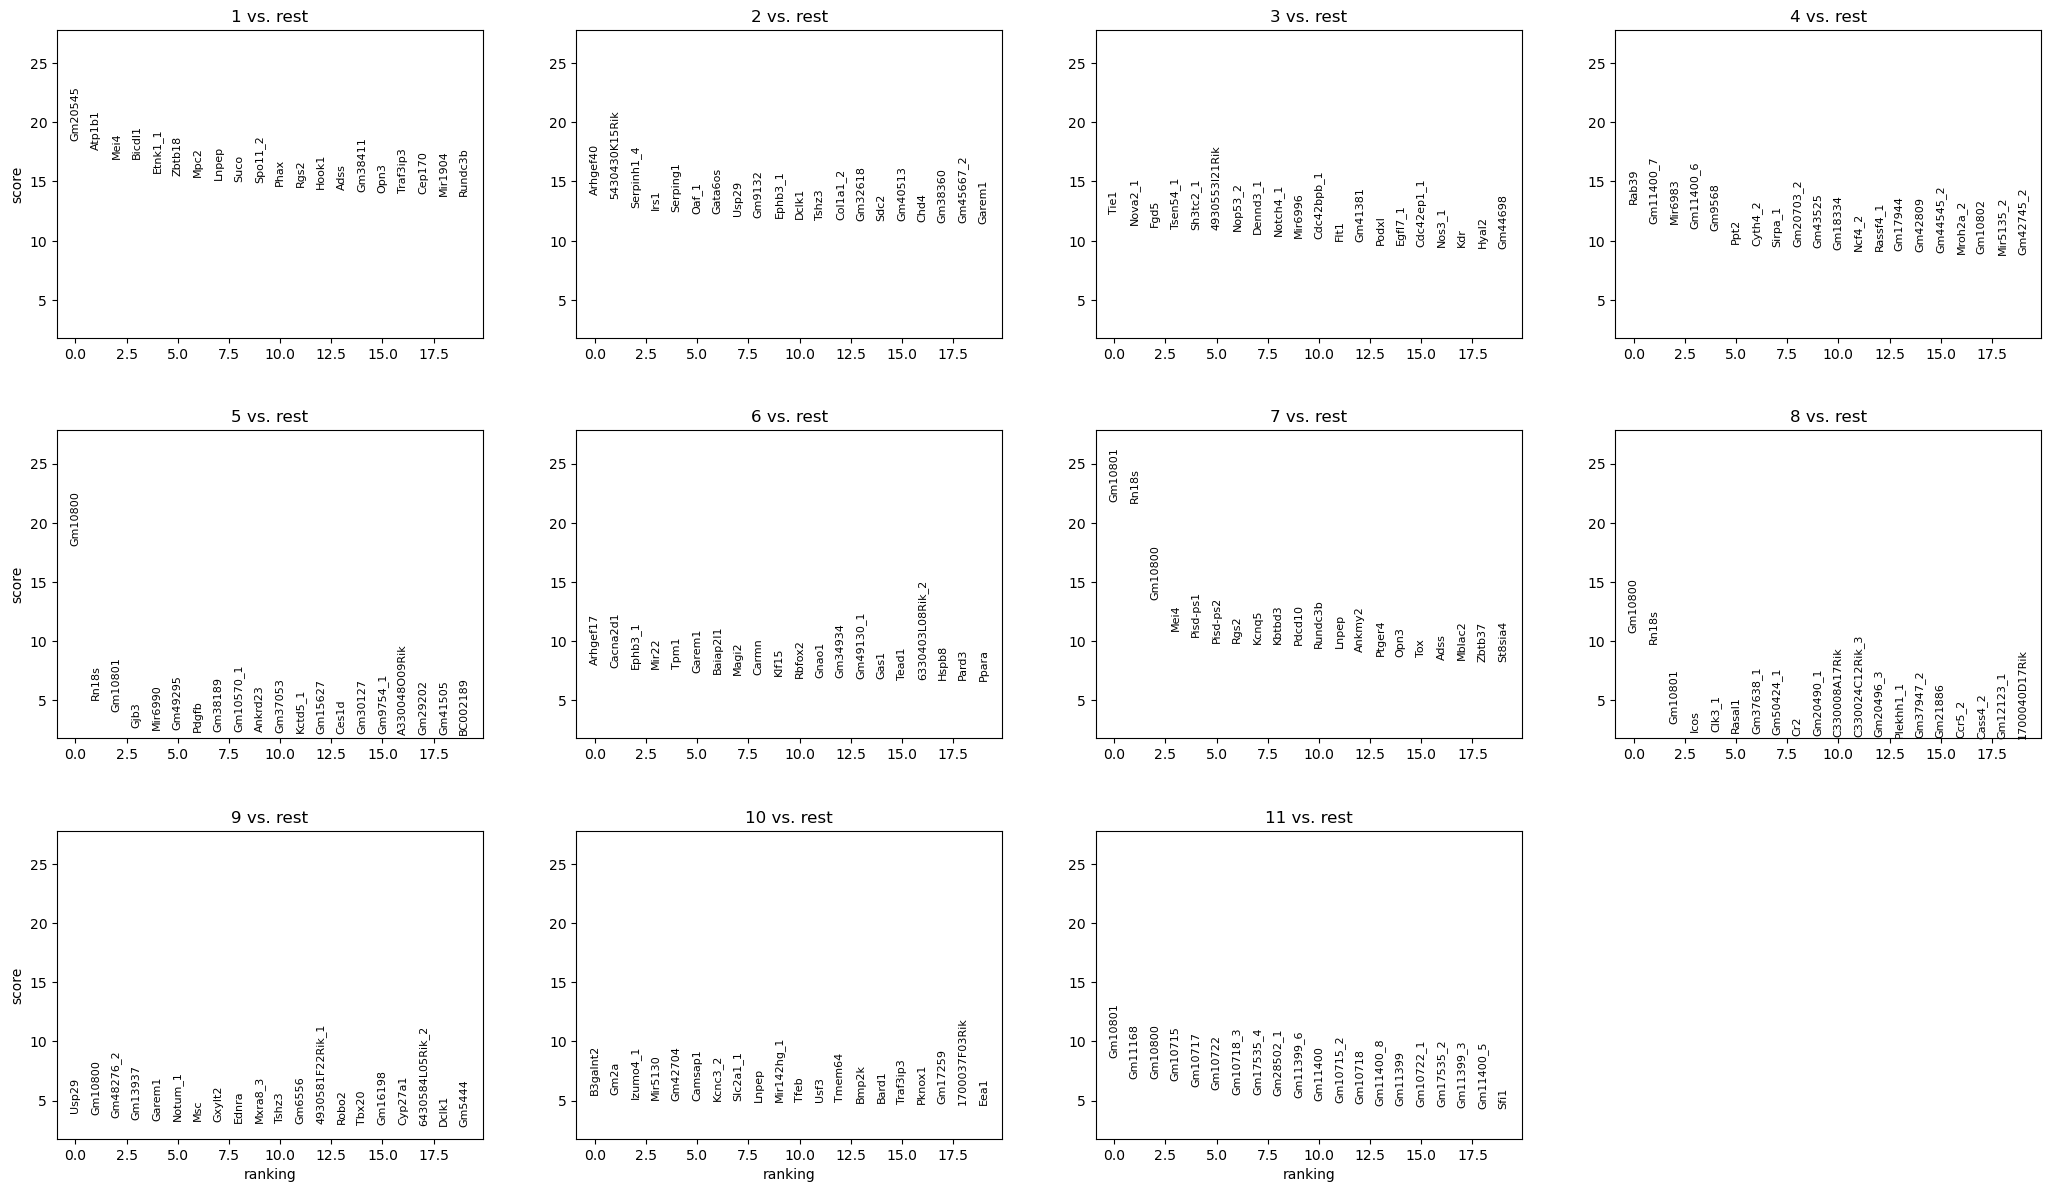

Plotting ranked genes groups for leiden with resolution: 0.6


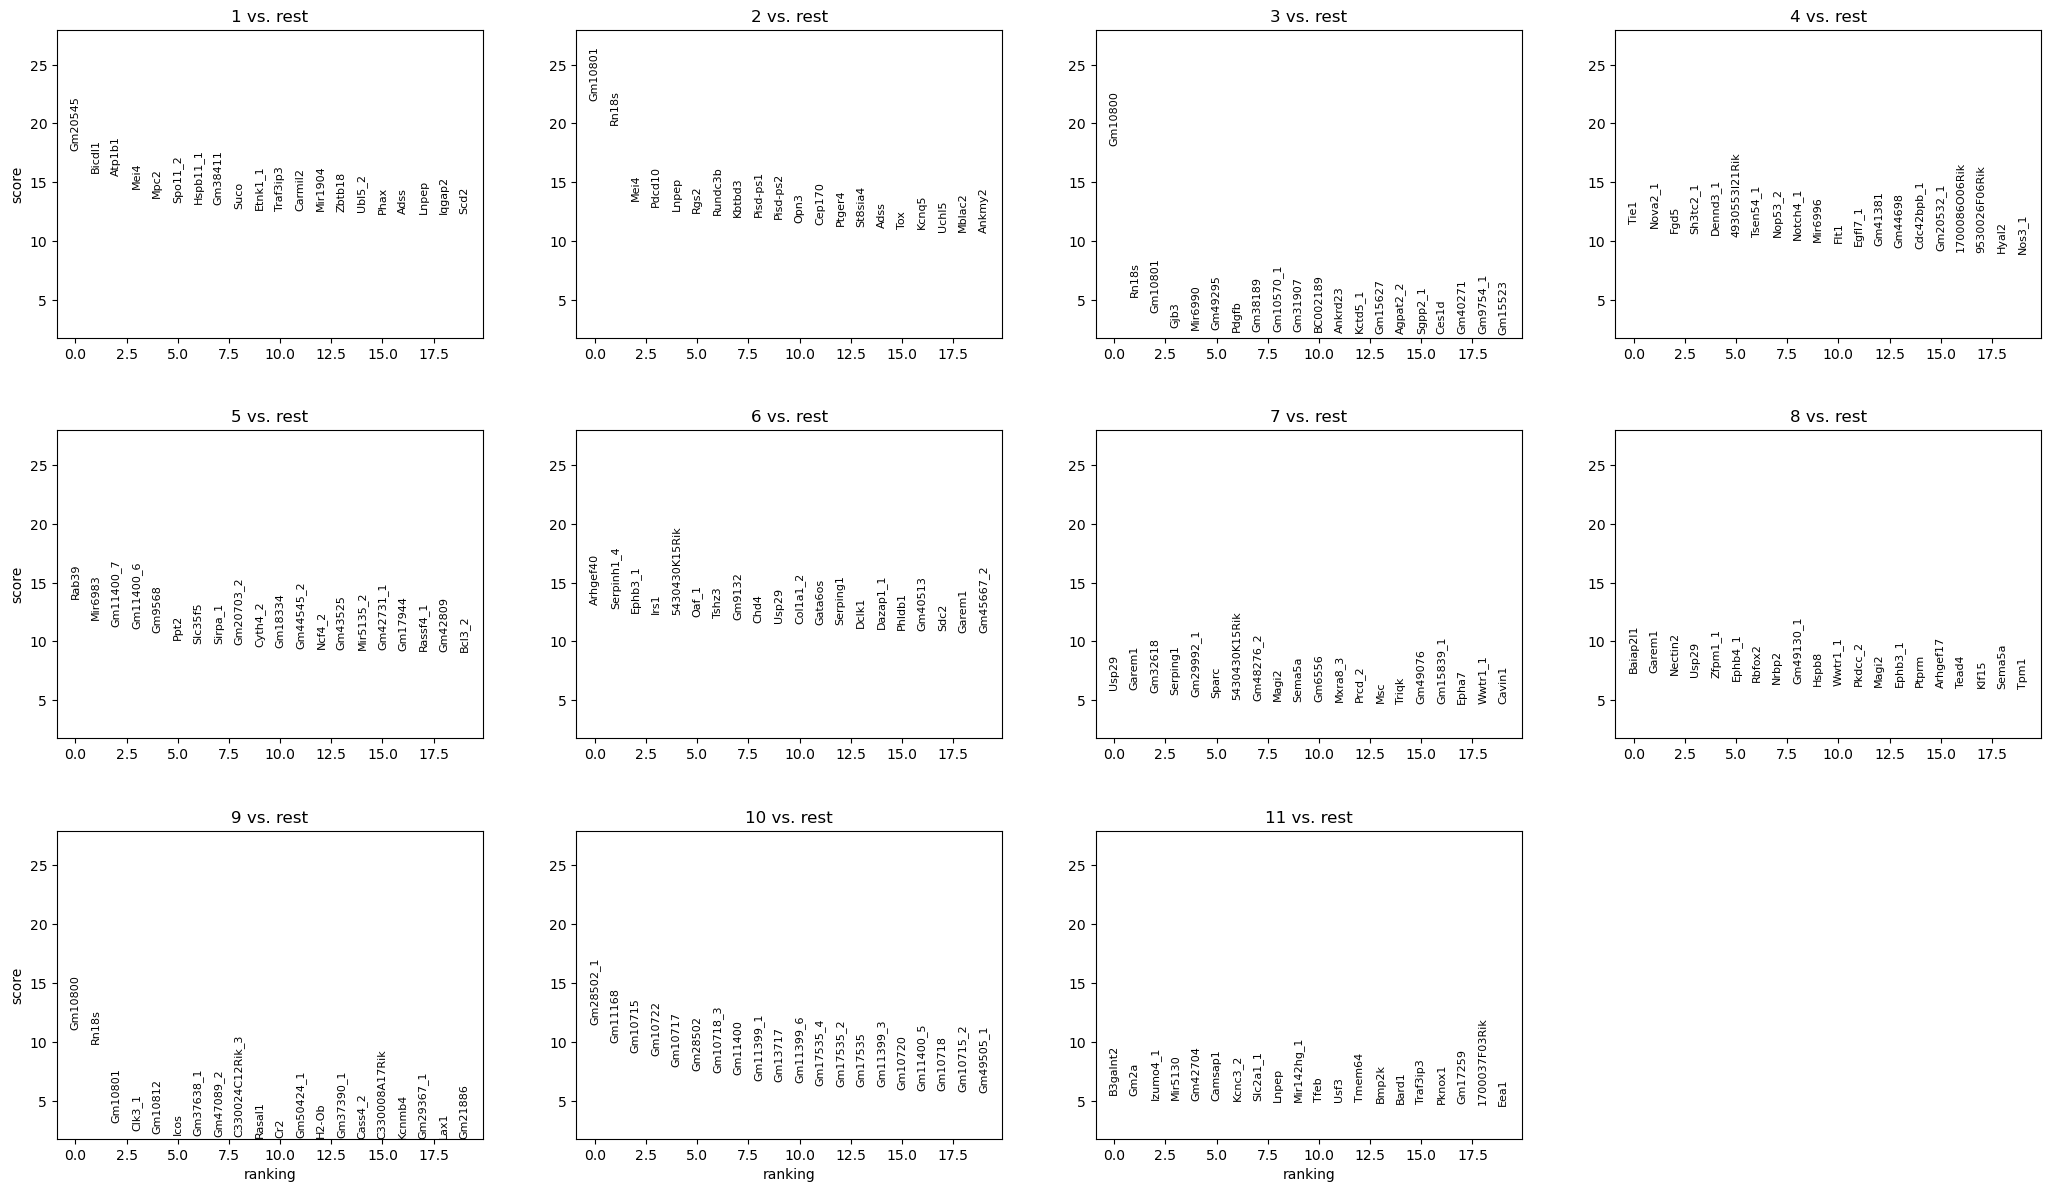

Plotting ranked genes groups for leiden with resolution: 0.7


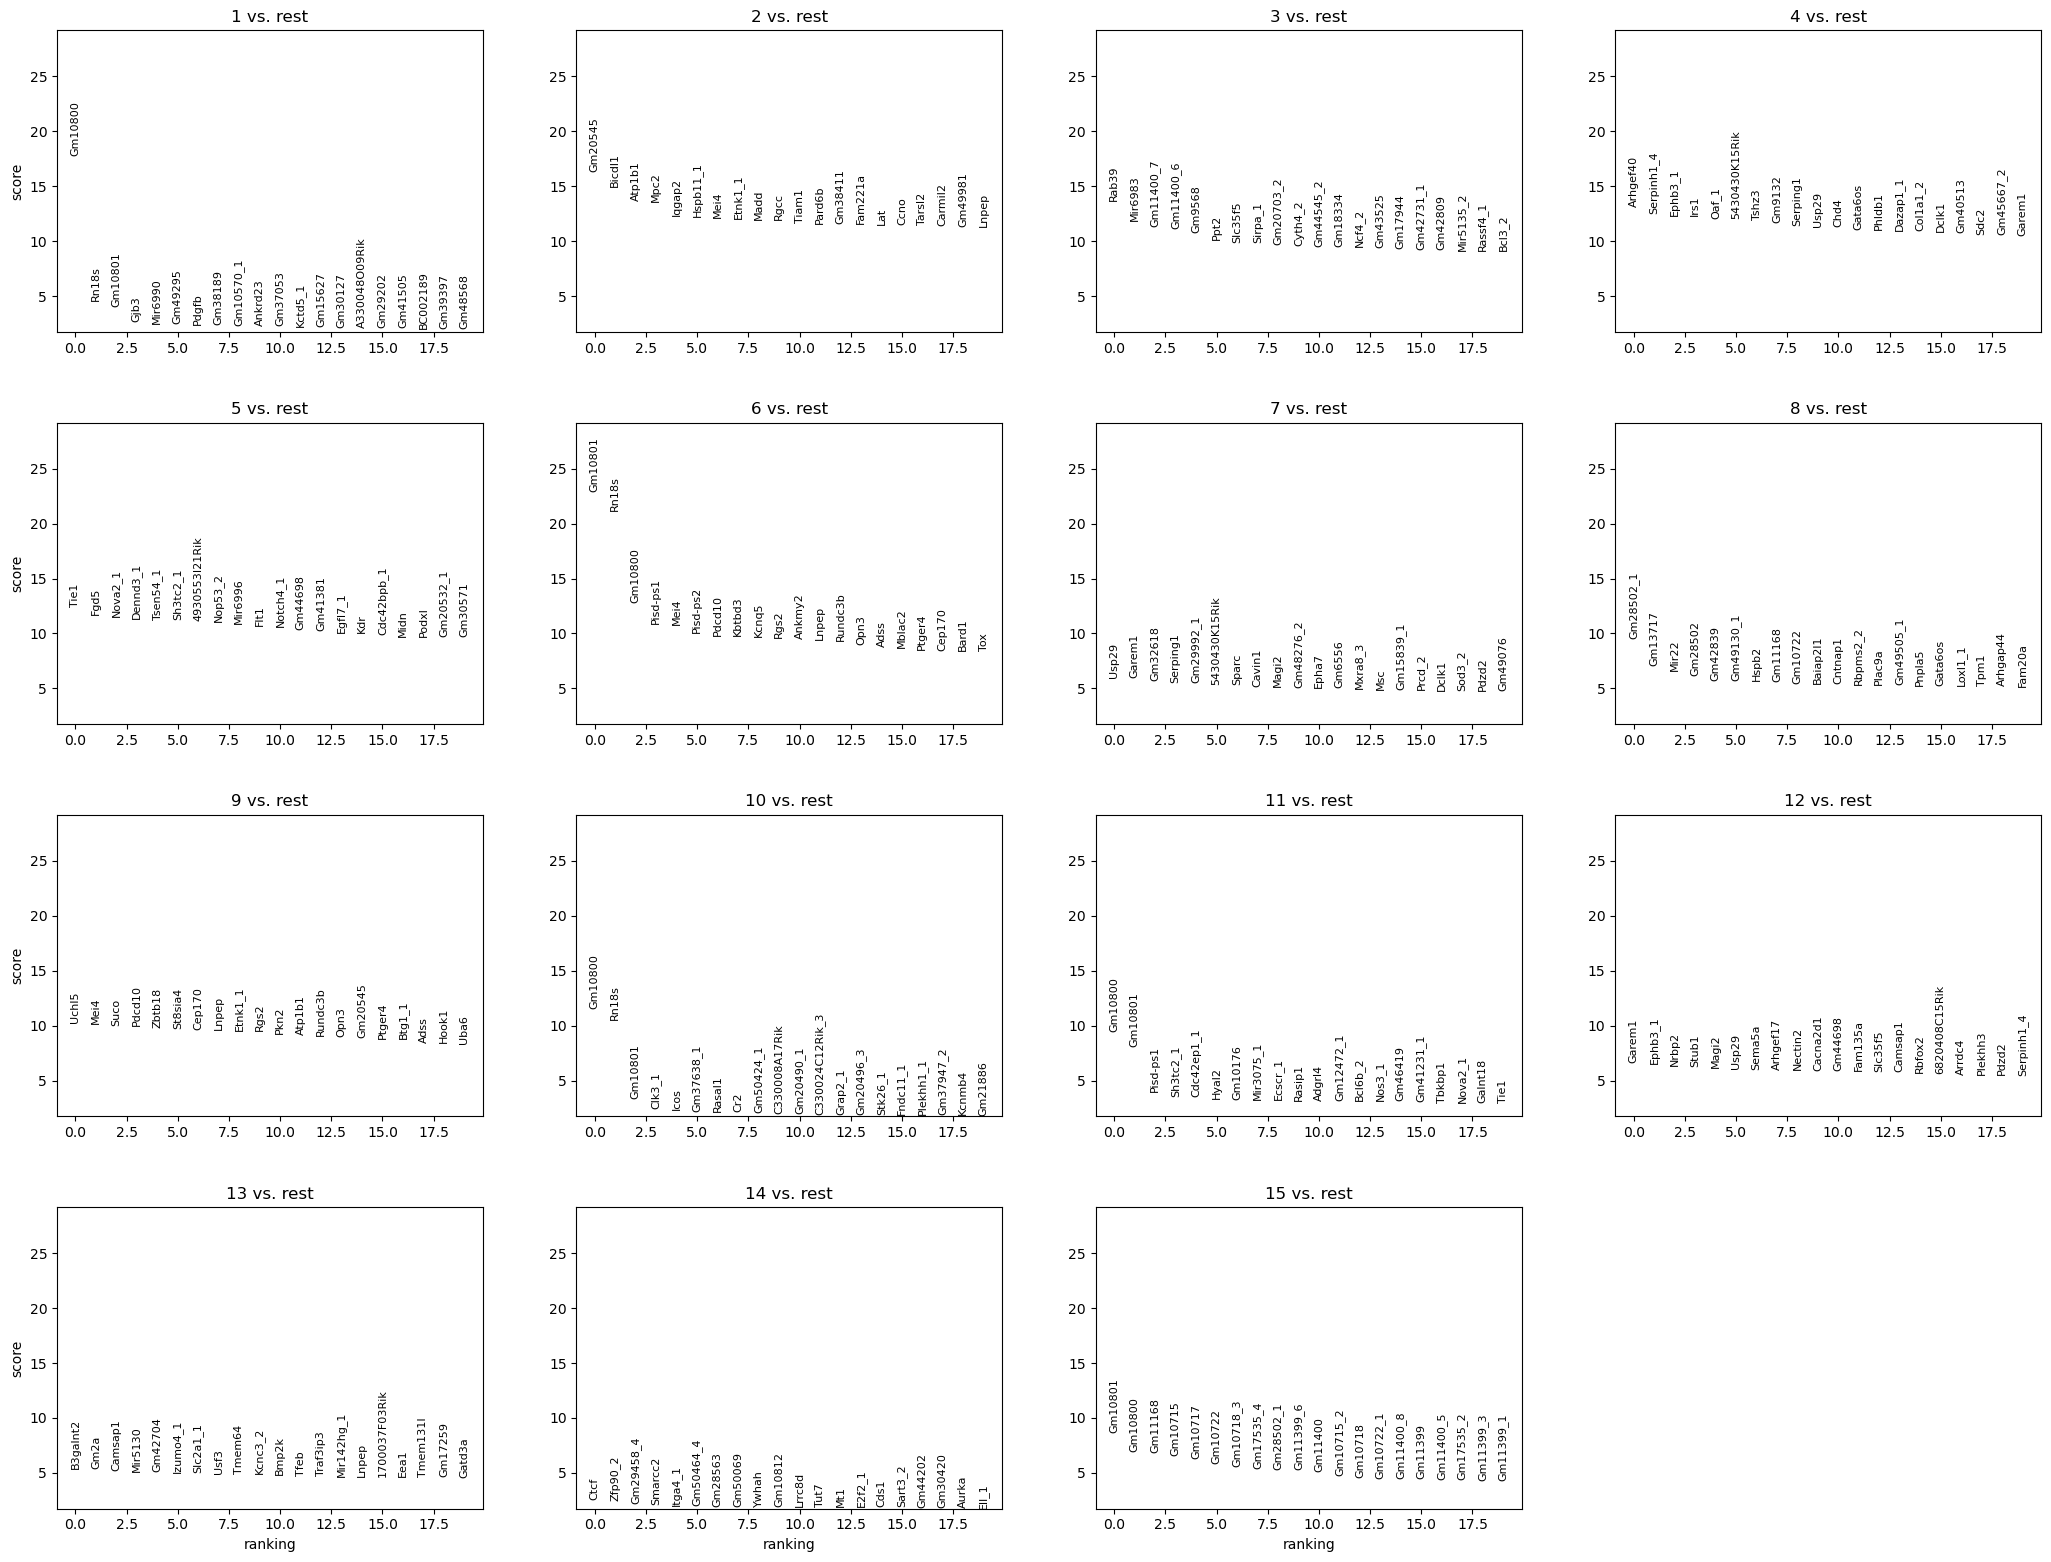

Plotting ranked genes groups for leiden with resolution: 0.8


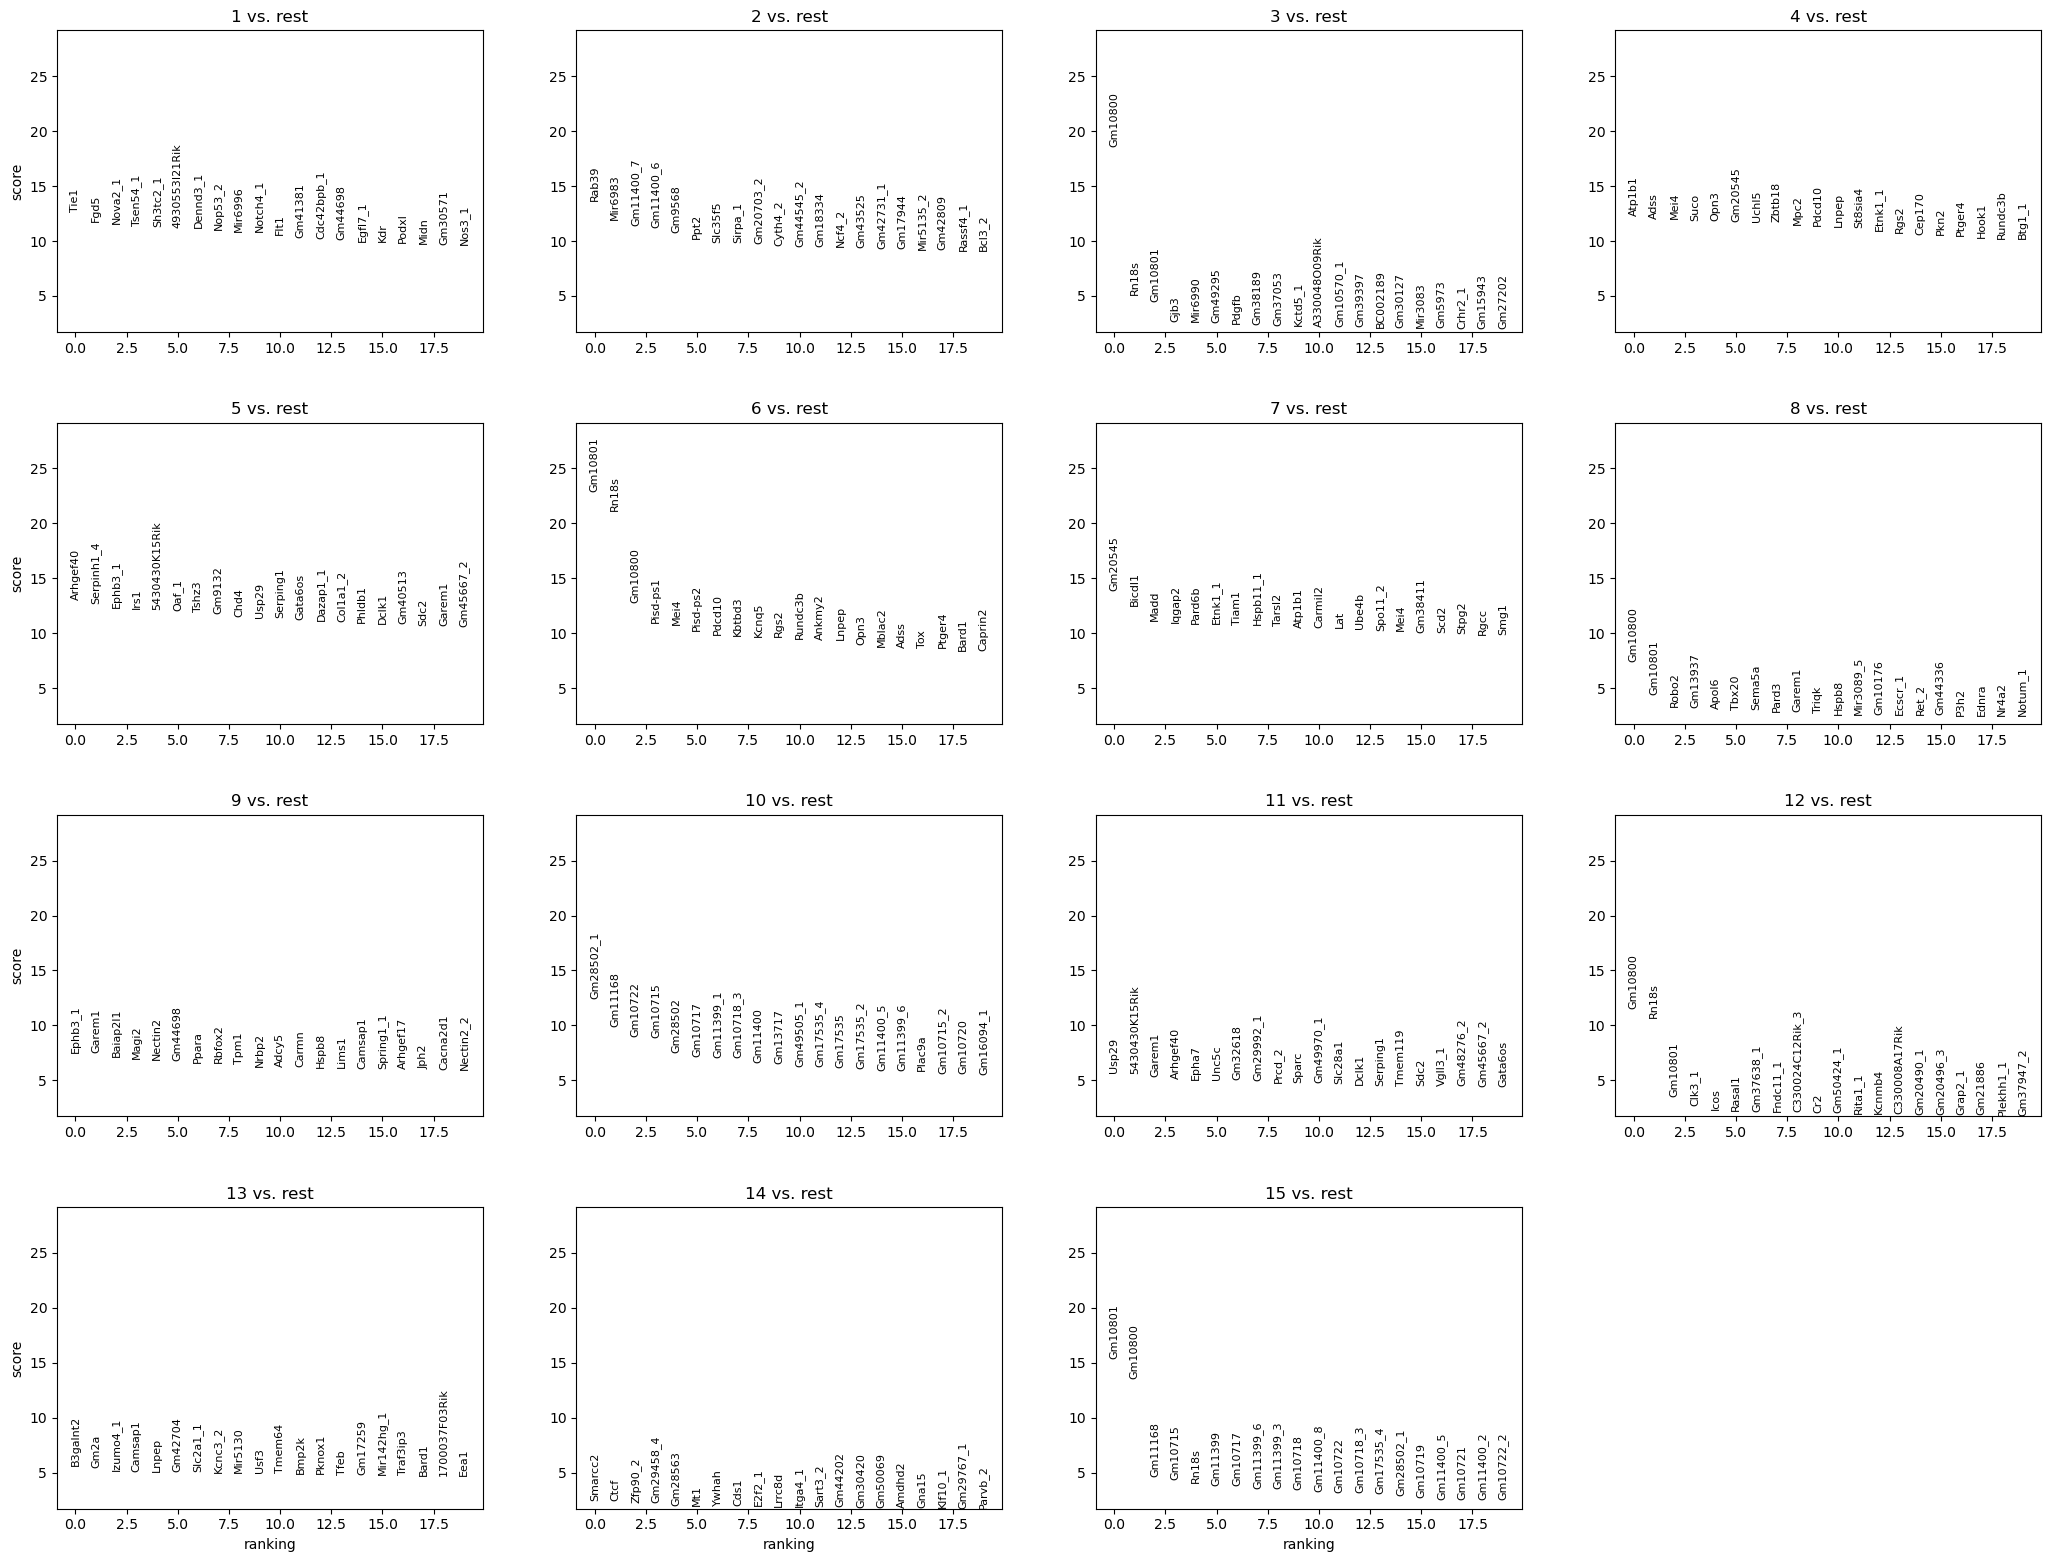

Plotting ranked genes groups for leiden with resolution: 0.9


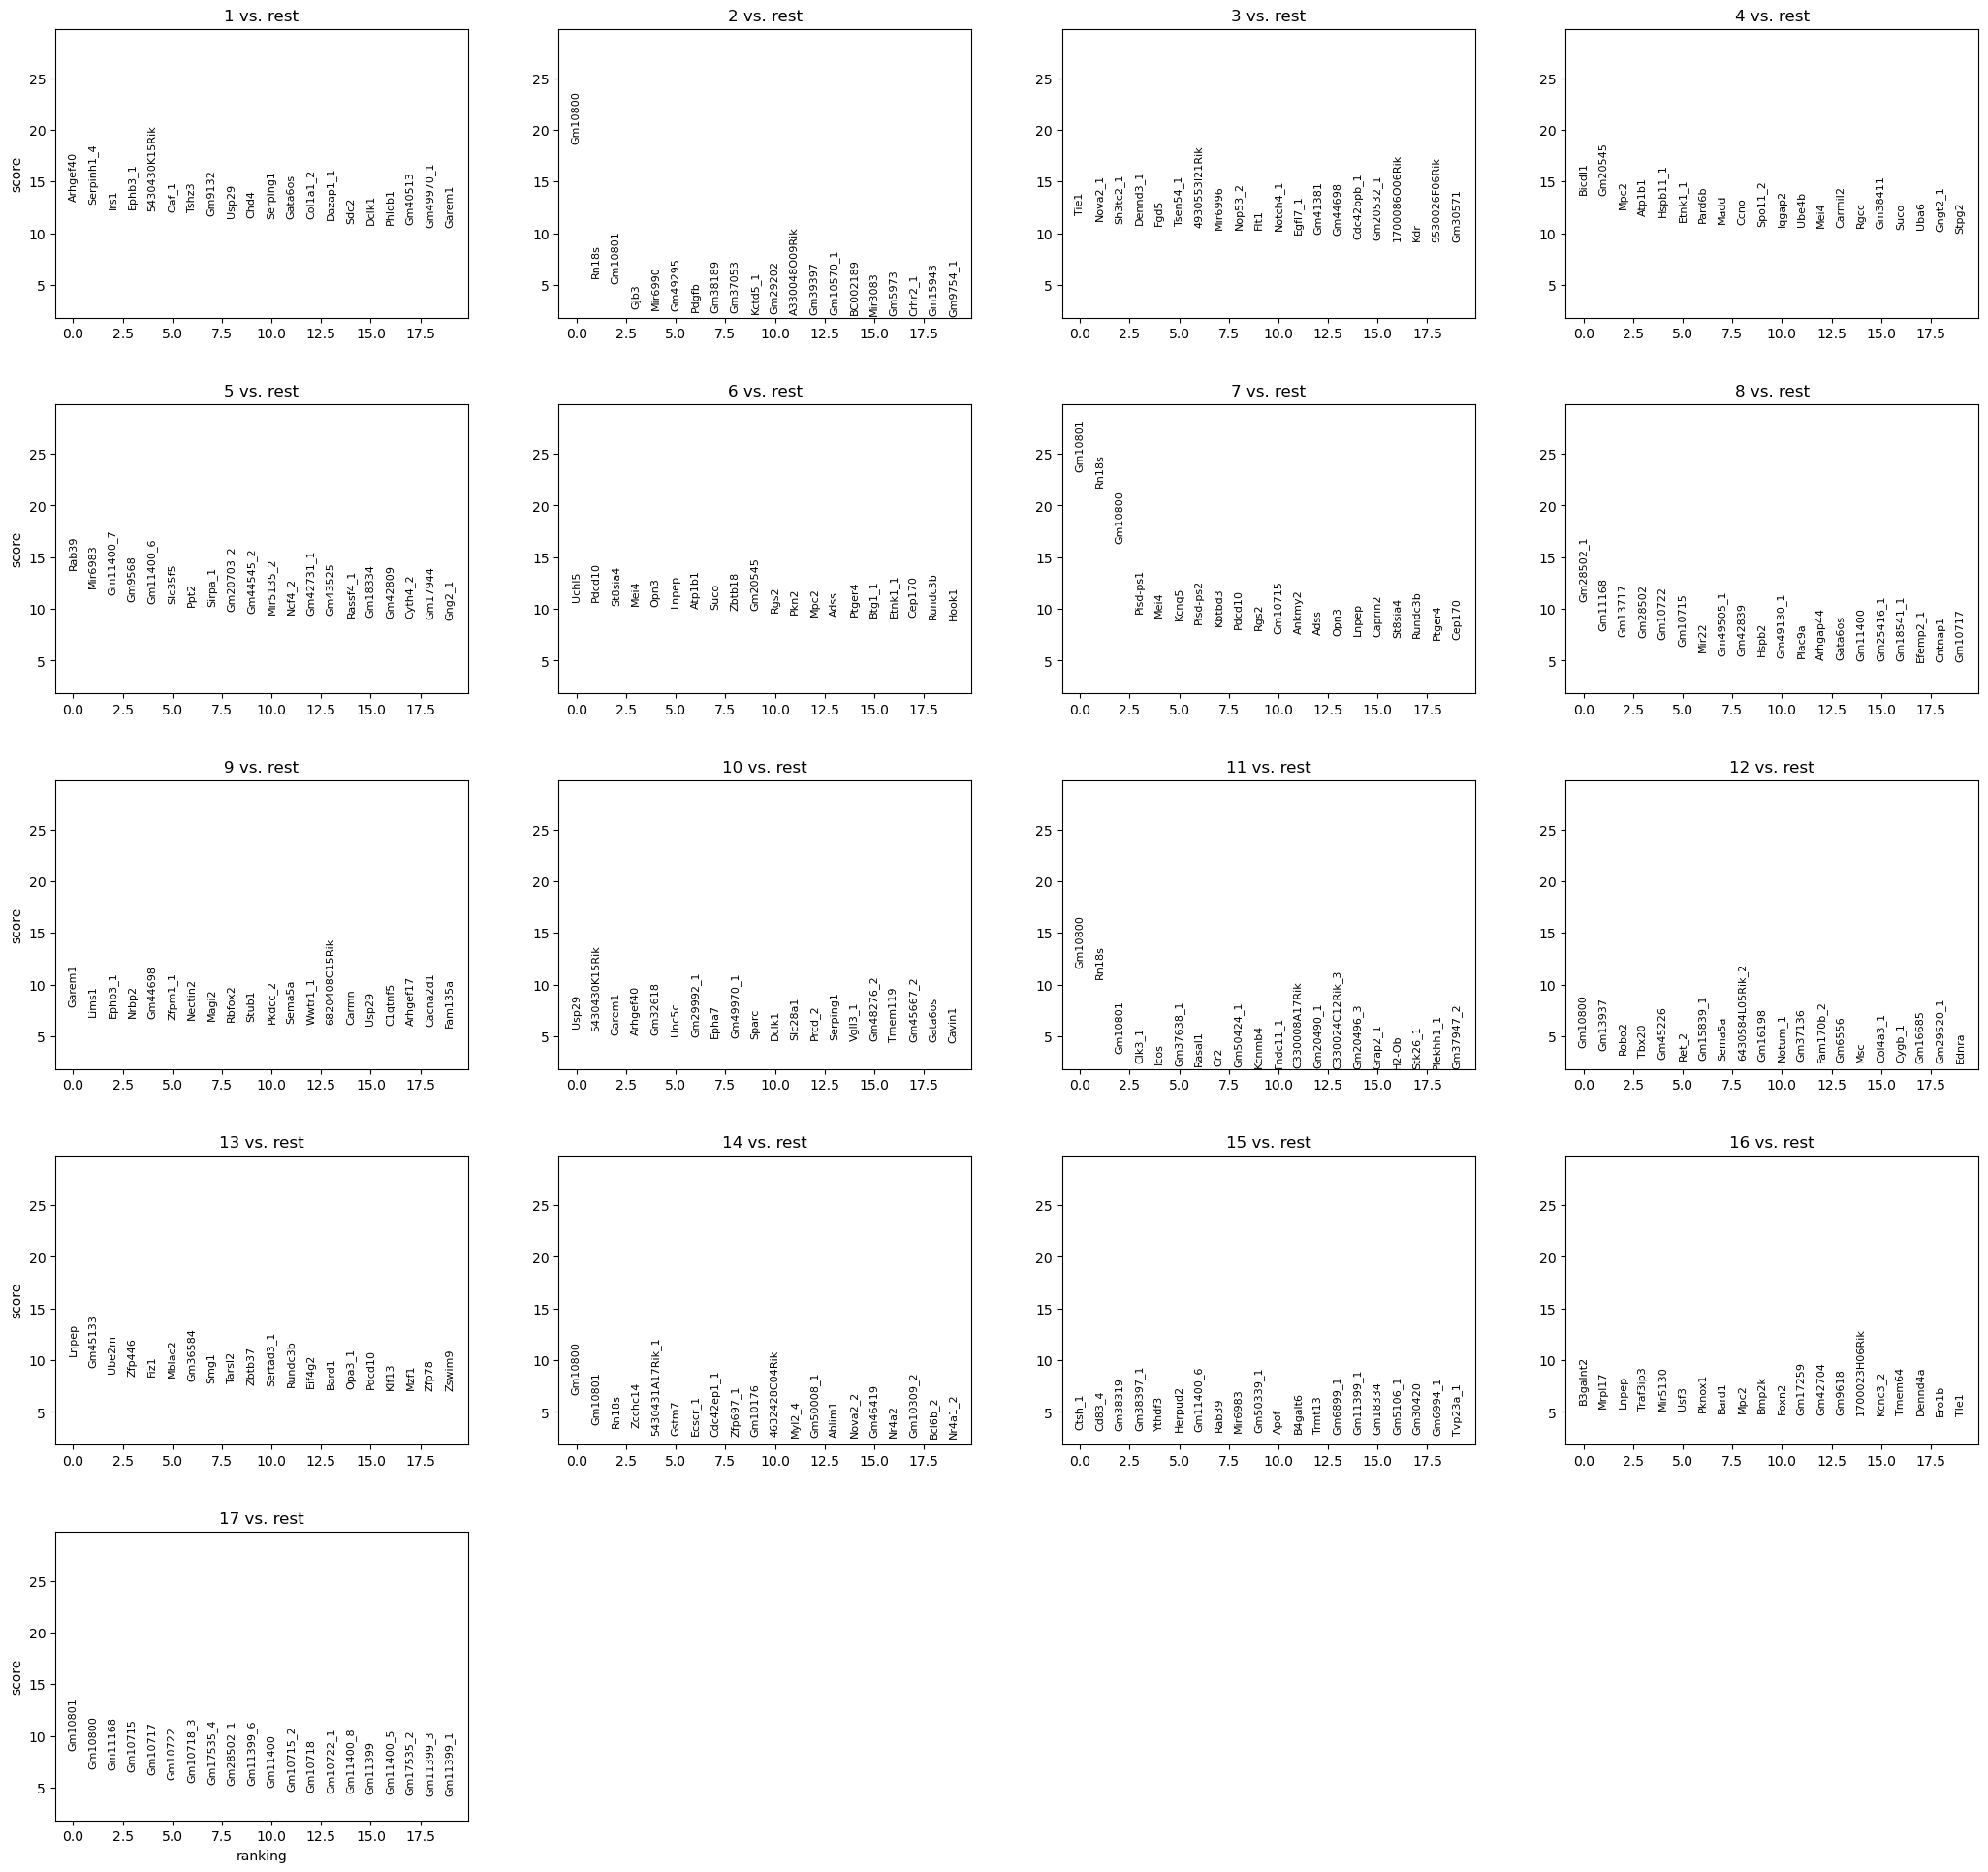

In [26]:
for res in resolutions:
    print(f'Plotting ranked genes groups for leiden with resolution: {res}')
    plot_key = 'rank_genes_groups_' + str(res)
    sc.pl.rank_genes_groups(genes_adata, key=plot_key, show=False)
    # TODO
    # if save_figs:
    #    plt.savefig(f'{OUTPUT_FIGS}/ranked_genes_groups_leiden_{res}.png')
    plt.show()

Plotting matrixplot for leiden with resolution: 0.1


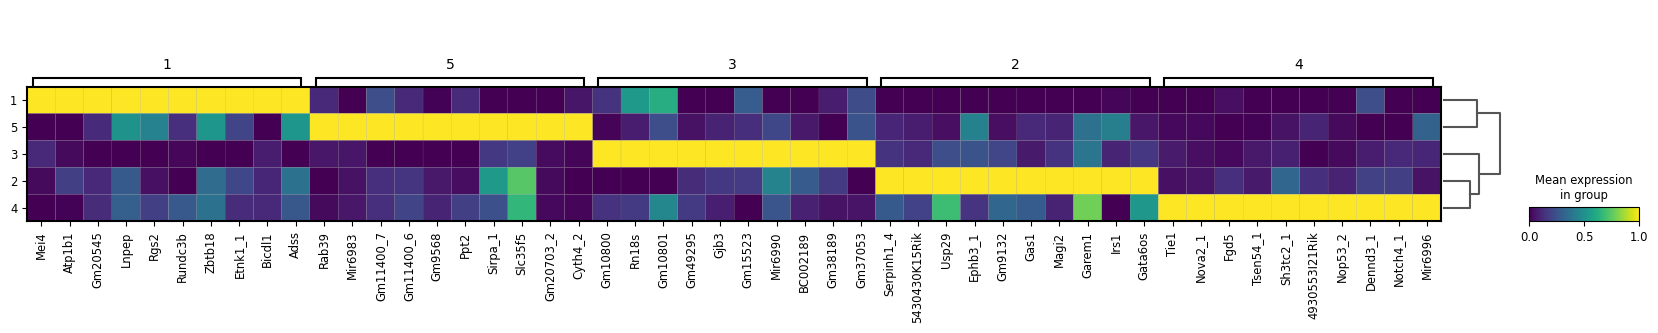

Plotting matrixplot for leiden with resolution: 0.2


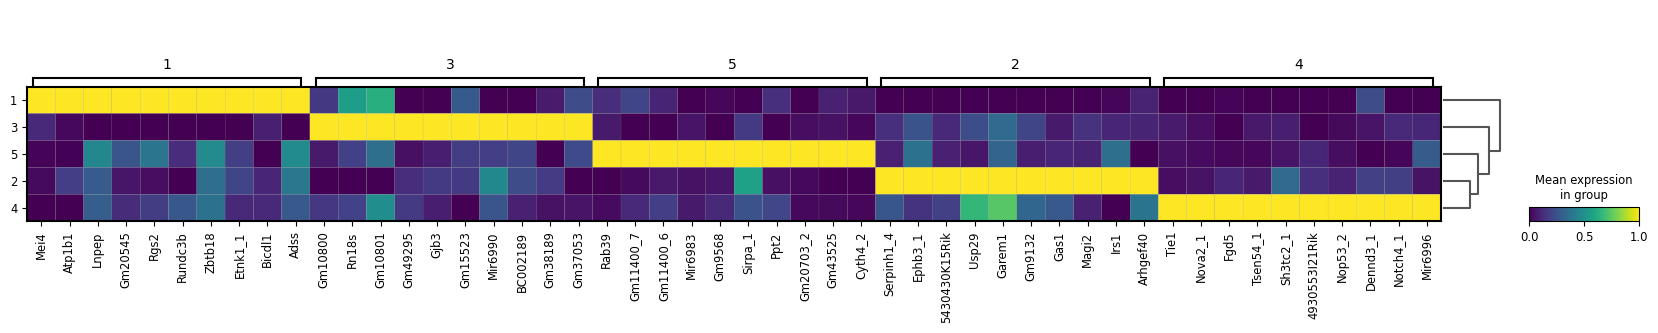

Plotting matrixplot for leiden with resolution: 0.3


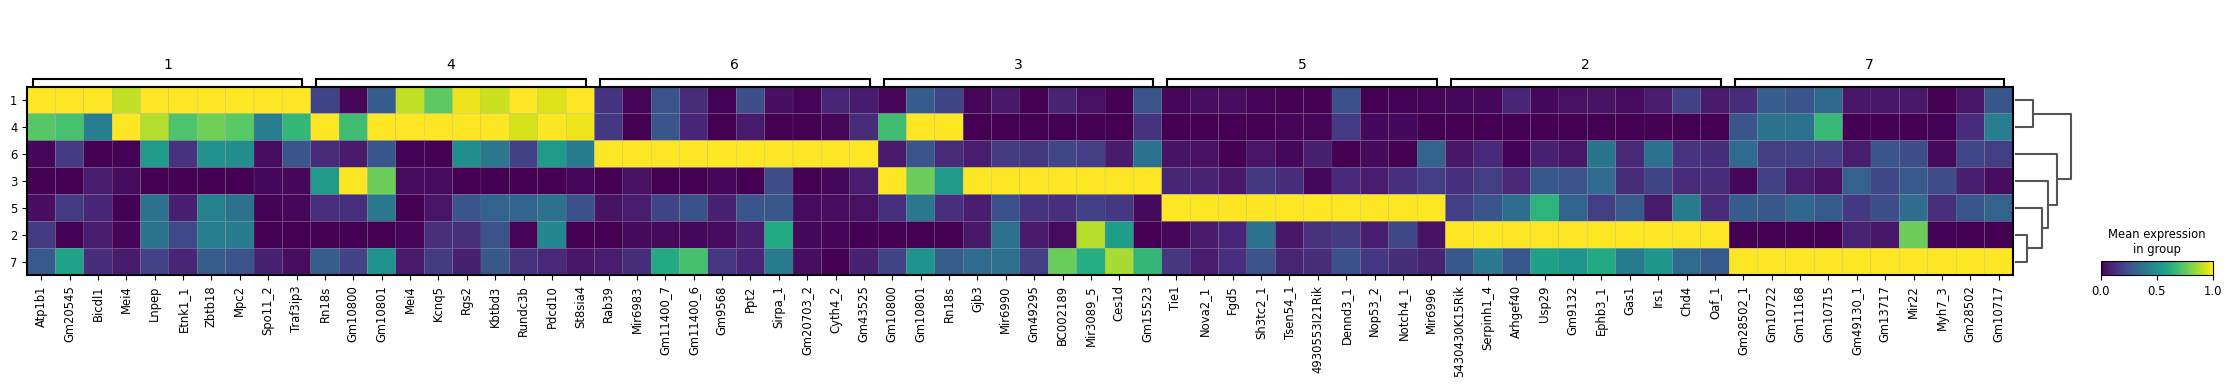

Plotting matrixplot for leiden with resolution: 0.4


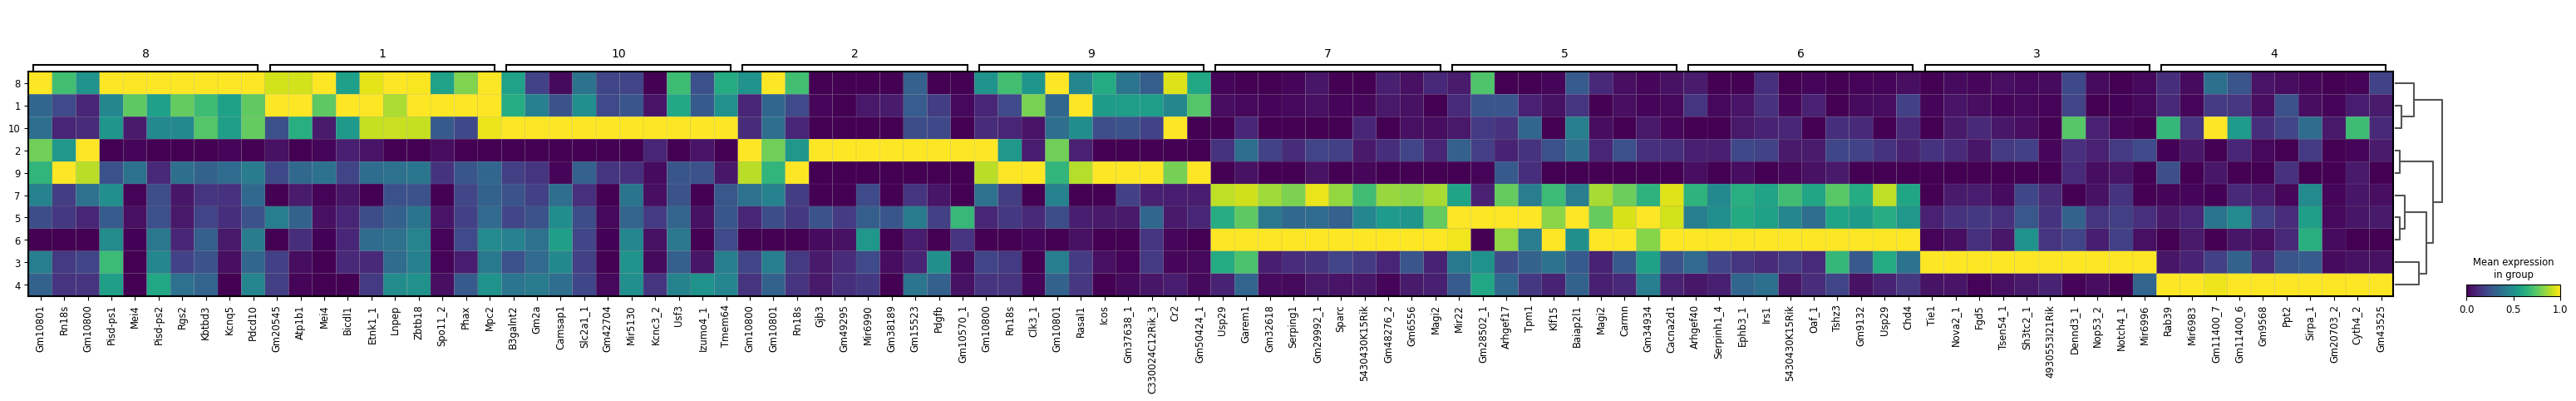

Plotting matrixplot for leiden with resolution: 0.5


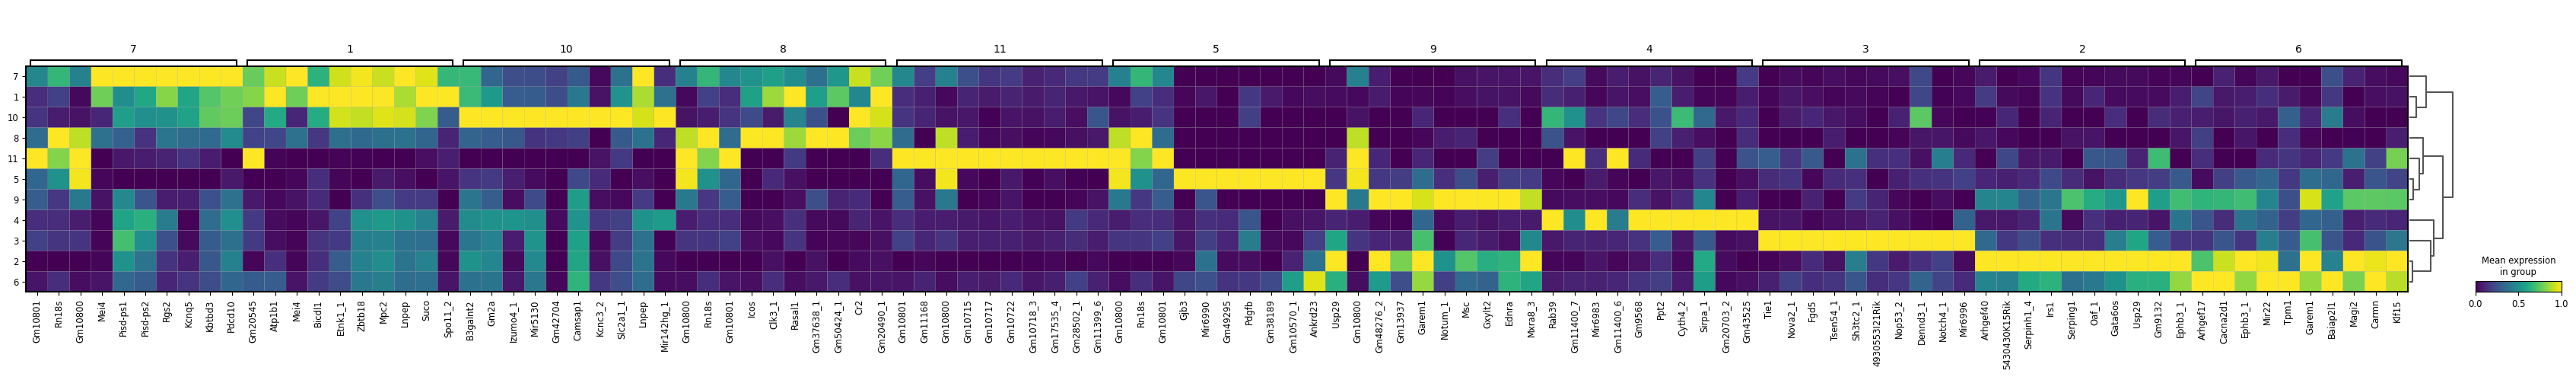

Plotting matrixplot for leiden with resolution: 0.6


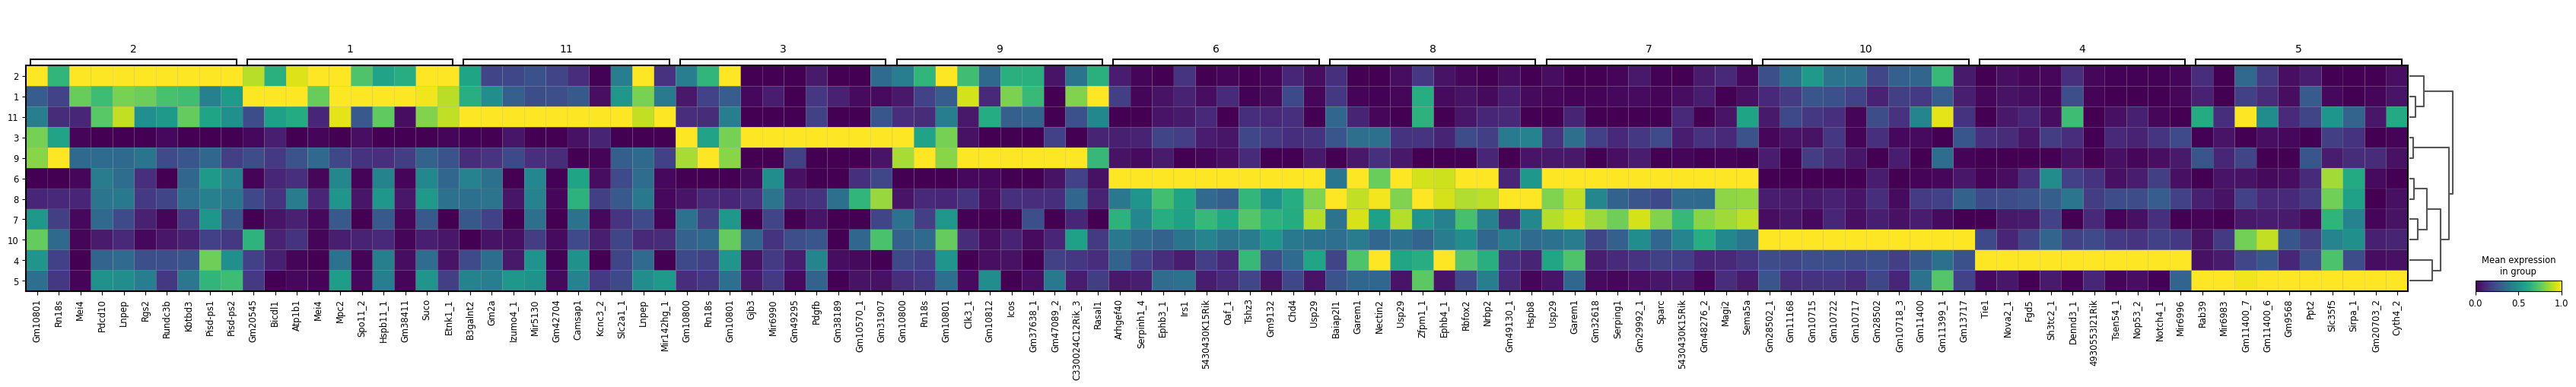

Plotting matrixplot for leiden with resolution: 0.7


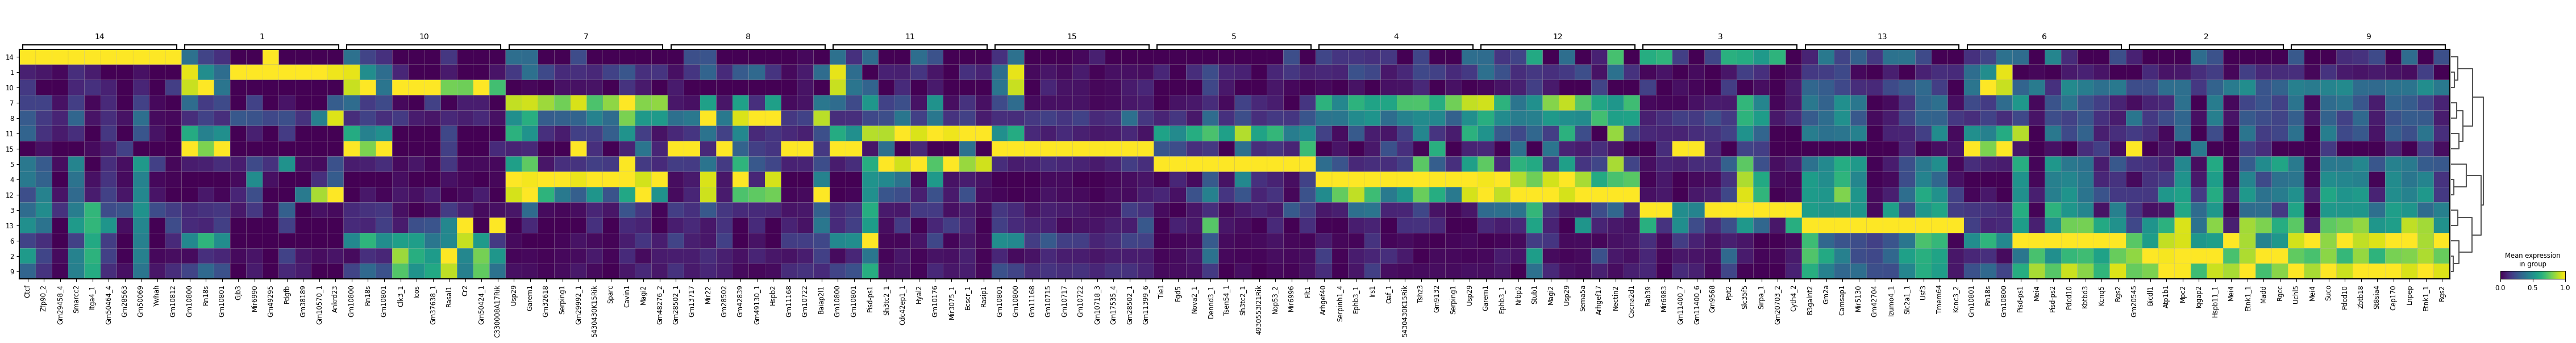

Plotting matrixplot for leiden with resolution: 0.8


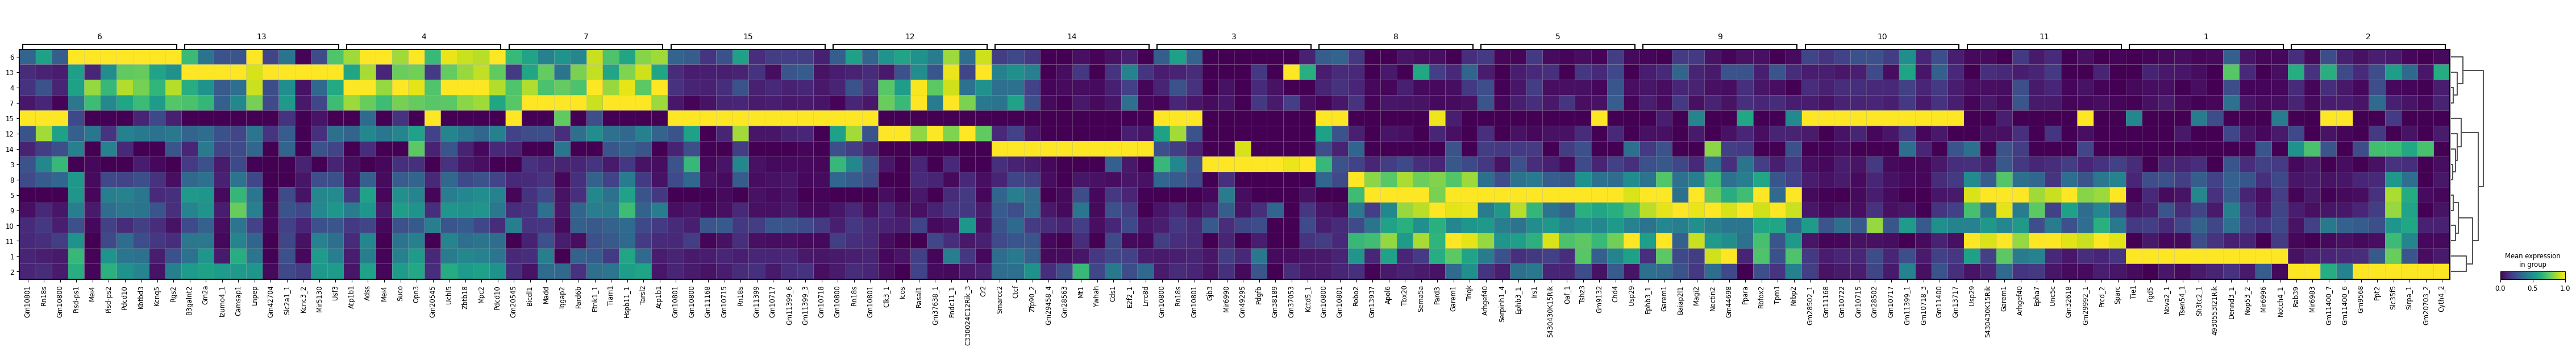

Plotting matrixplot for leiden with resolution: 0.9


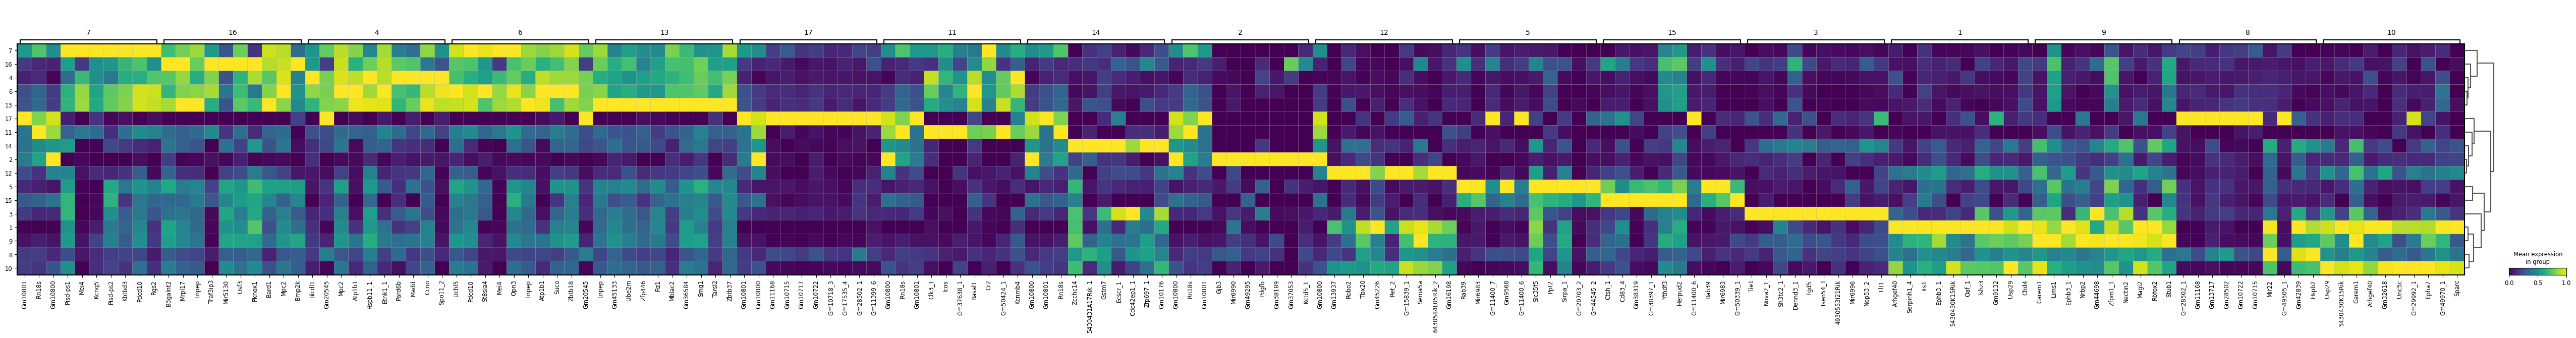

In [27]:
for res in resolutions:
    print(f'Plotting matrixplot for leiden with resolution: {res}')
    plot_key = 'rank_genes_groups_' + str(res)
    sc.pl.rank_genes_groups_matrixplot(genes_adata, standard_scale='var', n_genes=10, key=plot_key, show=False)
    # TODO
    # if save_figs:
    #    plt.savefig(f'{OUTPUT_FIGS}/ranked_genes_groups_matrixplot_leiden_{res}.png')
    plt.show()

In [28]:
for res in resolutions:
    ctannot.annot_ct(adata=adata, genes_adata=genes_adata, output_path=tree.annotation_dir, db_path=f"{PANGLAO_DB_PATH}", cluster_path=None, cluster_column=f"leiden_{res}", rank_genes_column=f"rank_genes_groups_{res}", sample=tree.run, ct_column=f"cell_types_{res}", tissue="all", db="panglao", inplace=True, species='Mm')

Output folder: /mnt/workspace/jdetlef/ext_ana/processed/sample1/annotation/leiden_0.1/ 
DB file: /mnt/workspace/jdetlef/sc-atac-framework/ctannot/panglao_markers 
Cluster folder: /mnt/workspace/jdetlef/ext_ana/processed/sample1/annotation/ranked/clusters/leiden_0.1/ 
Tissue: all 
DB: panglao
Writing one file per cluster containing gene names and ranked gene scores.
Starting cell type annotation.
Adding information to the adata object.
Finished cell type annotation! The results are found in the .obs table cell_types_0.1.
Output folder: /mnt/workspace/jdetlef/ext_ana/processed/sample1/annotation/leiden_0.2/ 
DB file: /mnt/workspace/jdetlef/sc-atac-framework/ctannot/panglao_markers 
Cluster folder: /mnt/workspace/jdetlef/ext_ana/processed/sample1/annotation/ranked/clusters/leiden_0.2/ 
Tissue: all 
DB: panglao
Writing one file per cluster containing gene names and ranked gene scores.
Starting cell type annotation.
Adding information to the adata object.
Finished cell type annotation! The 

In [30]:
adata.obs

,chr1_reads,chr10_reads,chr11_reads,chr12_reads,chr13_reads,chr14_reads,chr15_reads,chr16_reads,chr17_reads,chr18_reads,...,clustering,cell_types_0.1,cell_types_0.2,cell_types_0.3,cell_types_0.4,cell_types_0.5,cell_types_0.6,cell_types_0.7,cell_types_0.8,cell_types_0.9
barcode,,,,,,,,,,,,,,,,,,,,,
CCATGATGAATCTGTG-sample1,5930,5367,657,2109,14960,3999,15397,6899,4282,6064,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TGTTATCACGCTAGAG-sample1,4786,4055,3375,4053,3294,3010,3192,2737,3509,2867,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GAACTACTGTATTGCG-sample1,1564,612,2039,2309,1834,2987,1444,907,1517,1515,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TACCGACCTCGAACGA-sample1,4176,3330,2550,2547,2076,2622,1893,2194,1571,1546,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TGAATGGCTTAGGAGC-sample1,1981,1118,899,627,885,971,1104,850,830,525,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TATTCAGCTTGGAACG-sample1,50,55,88,28,48,40,86,42,48,32,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CCTGCCTCTAGCGCTC-sample1,44,58,66,34,42,34,38,28,54,24,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TGGTTAGACACACAAA-sample1,46,100,58,36,44,22,26,32,54,34,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


StopIteration: 

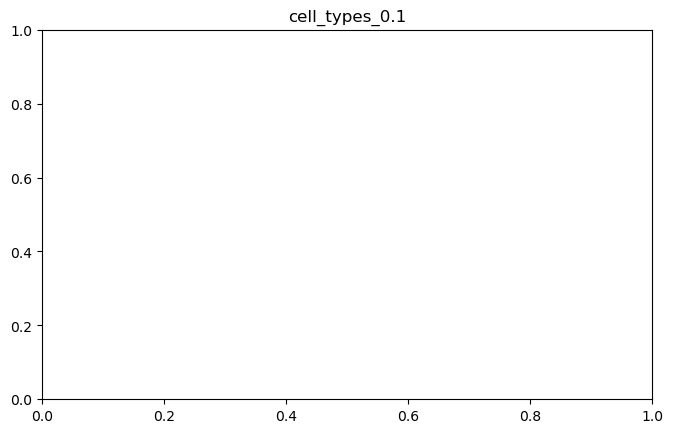

In [29]:
for res in resolutions:
    sc.pl.umap(adata, color=[f'cell_types_{res}', f'leiden_{res}'], wspace=0.5)

## Modify wrong cluster annotations by selecting other recommendations

In [ ]:
ctannot.modify_ct(adata=adata, resolutions=resolutions, annotation_dir=tree.annotation_dir, clustering_column="leiden", cell_type_column="cell_types", inplace=True)

In [ ]:
sc.pl.umap(adata, color=[f'cell_types_mod_0.1', f'cell_types_0.1'], wspace=0.5)